# Creating Plots for Analysis and Article

In [55]:
import datetime
from os.path import join

from collections import defaultdict

import geopandas as gp
import numpy as np
import pandas as pd
import plotnine as gg
from scipy.stats import chisquare, tstd, ttest_ind, ttest_1samp, permutation_test,chi2_contingency, pearsonr

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
img_dest = "/Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets"

# Create Database Connection

In [56]:
db = CurlingDB(db_name='world_curling_ss.db')

## Setup

In [57]:
# All values in m
circles = [0.152, 0.610, 1.219, 1.829]
pixel_to_m = 0.007370759
ice_width = [-4.75/2, 4.75/2]
ice_length = [-2, 6.401]
stone_radius = 14.5

# Circle values
inc = np.pi / 16
circle_range_x = np.cos(np.arange(0, 2 * np.pi + inc, inc))
circle_range_y = np.sin(np.arange(0, 2 * np.pi + inc, inc))

# Plotting

## Heatmaps

### Data Collection

In [58]:
stone_position_cmd = """
SELECT x, y, colour, frame_num, m.type,
       CASE WHEN s.size < 47 THEN (CASE WHEN s.colour == 'red' THEN 'pink' WHEN s.colour == 'yellow' THEN 'green' END)
            ELSE s.colour END AS label
FROM Stone s
JOIN Position p
  ON s.position_id = p.position_id
JOIN End e
  ON p.end_id = e.end_id
JOIN Match m
  ON e.match_id = m.match_id
"""
db.execute_query(stone_position_cmd)
all_stone_positions = pd.DataFrame(db.cursor.fetchall(), columns=['x', 'y', 'colour', 'frame_num', 'match_type', 'label'])
print(all_stone_positions.shape)
all_stone_positions.head()

(1053163, 6)


x         y  colour  frame_num    match_type  label
0  1.757926  1.245658     red          2  Womens_Teams   pink
1  1.761611  1.238288     red          3  Womens_Teams    red
2  0.117932 -1.370961  yellow          3  Womens_Teams  green
3  1.765297  1.238288     red          4  Womens_Teams    red
4  0.644941  0.796042     red          4  Womens_Teams   pink

In [59]:
mens_stones = all_stone_positions.query('match_type == "Mens_Teams"')
print(mens_stones.shape)
womens_stones = all_stone_positions.query('match_type == "Womens_Teams"')
print(womens_stones.shape)
doubles_stones = all_stone_positions.query('match_type == "Mixed_Doubles"')
print(doubles_stones.shape)
para_stones = all_stone_positions.query('match_type == "Mixed_Teams"')
print(para_stones.shape)

(353486, 6)
(327267, 6)
(316801, 6)
(55609, 6)


In [60]:
def thrown_stones(df: pd.DataFrame) -> pd.DataFrame:
    return df.query('(label == "pink") | (label == "green")')

def residual_stones(df: pd.DataFrame) -> pd.DataFrame:
    return df.query('(label == "red") | (label == "yellow")')

def regular(df: pd.DataFrame) -> pd.DataFrame:
    return df.query('(match_type == "Mens_Teams") | (match_type == "Womens_Teams")')

def non_neg_rating(df: pd.DataFrame) -> pd.DataFrame:
    return df.query('rating != -1')

### Stones Thrown in Men's and Women's Matches

#### Plot Function

In [61]:
circle_size = 1.5
circle_colour = '#ffffff'
def mw_stone_heatmap(df, title: str, binwidth=0.1, size=5):

     width = (df.frame_num.max())
     height = ((800 + 300)/(600))
     
     return ((gg.ggplot(df, gg.aes(x='x', y='y'))
          + gg.geom_bin_2d(binwidth=binwidth)
          + gg.facet_grid('. ~ frame_num')
          + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour=circle_colour, size=circle_size)
          + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour=circle_colour, size=circle_size)
          + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour=circle_colour, size=circle_size)
          + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour=circle_colour, size=circle_size)

          + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
          + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
          # + gg.scale_fill_gradientn(colors=['#dddddd', '#888888', '#444444', '#000000', '#000000'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
          # + gg.scale_fill_gradientn(colors=['#000000', '#880000', '#d64302', '#ff4f00', '#ff4f00'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
          # + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#ff4f00', '#ffd000', '#ffd000'], values=[0, 0.08, 0.3, 1], guide=False)
          # + gg.scale_fill_gradientn(colors=['#ffffff', '#ff4f00', '#aa0000', '#aa0000'], values=[0, 0.08, 0.3, 1], guide=False)
          + gg.scale_fill_gradientn(colors=['#000000', '#000000', '#ff4f00', '#13FFD5', '#13FFD5'], values=[0, 0.15, 0.4, 0.8, 1], guide=False, trans='log')

          + gg.theme(text=gg.element_text(colour='#ffffff', size=32), title=gg.element_text(size=48, ha='left'))
          + gg.theme(axis_text=blank, axis_title=blank)
          + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0)
          + gg.theme(panel_border=gg.element_line(size=2))
          + gg.theme(figure_size=(size * df.frame_num.max(), size * ((800 + 300)/(600))))

          + pe.background_colour(panel_colour='#000000', plot_colour='#000000')
          + pe.remove_ticks(minor=True)
          + pe.labels(title=title)
          ), width, height)


def doub_stone_heatmap(df, title: str, binwidth=0.1, size=5):

     width = (df.frame_num.max() + 1)
     height = ((800 + 300)/(600))
     
     return ((gg.ggplot(df, gg.aes(x='x', y='y'))
          + gg.geom_bin_2d(binwidth=binwidth)
          + gg.facet_grid('. ~ frame_num')
          + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour=circle_colour, size=circle_size)
          + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour=circle_colour, size=circle_size)
          + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour=circle_colour, size=circle_size)
          + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour=circle_colour, size=circle_size)

          + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
          + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
          # + gg.scale_fill_gradientn(colors=['#dddddd', '#888888', '#444444', '#000000', '#000000'], values=[0, 0.01, 0.05, 0.1, 1], guide=False)
          + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#13FFD5', '#13FFD5'], values=[0, 0.2, 0.6, 1], guide=False, trans='log')

          + gg.theme(text=gg.element_text(colour='#ffffff', size=32), title=gg.element_text(size=48, ha='left'))
          + gg.theme(axis_text=blank, axis_title=blank)
          + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0)
          + gg.theme(panel_border=gg.element_line(size=2))
          + gg.theme(figure_size=(size * (df.frame_num.max() + 1), size * ((800 + 300)/(600))))

          + pe.background_colour(panel_colour='#000000', plot_colour='#000000')
          + pe.remove_ticks(minor=True)
          + pe.labels(title=title)
          ), width, height)

#### MW Plots

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 80 x 9.166666666666666 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Heatmap_Quads.png


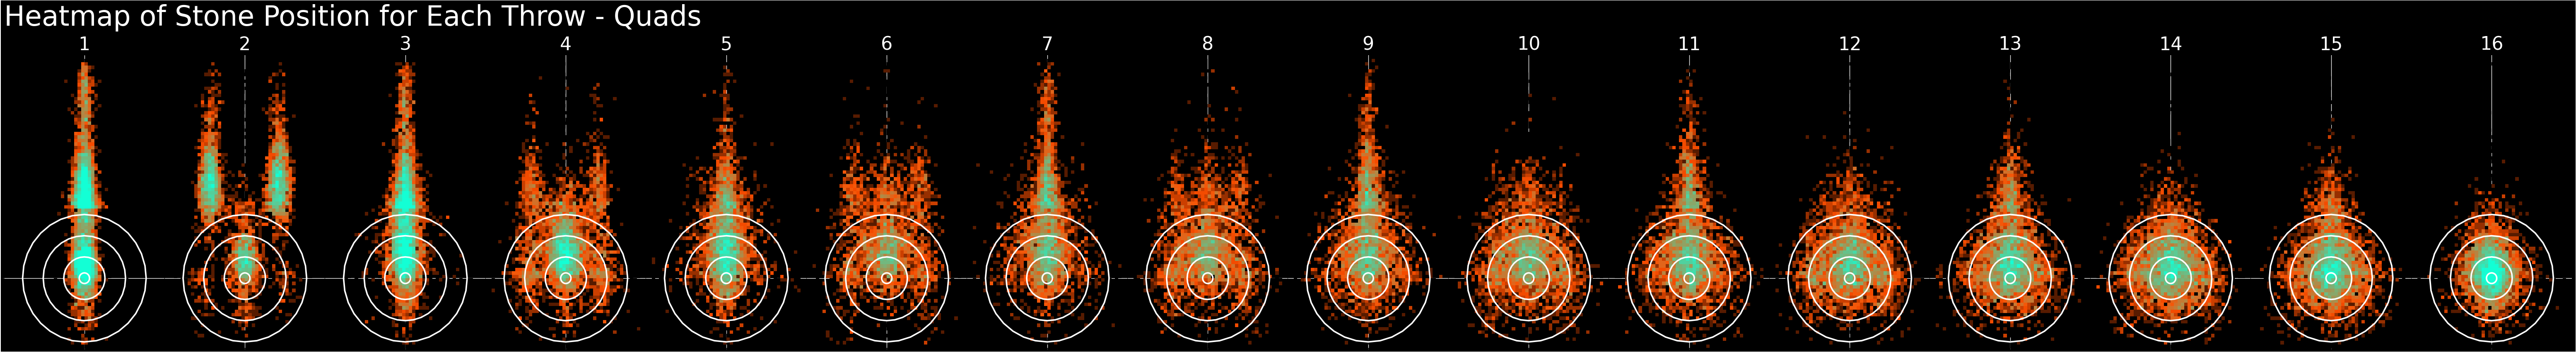

<ggplot: (716364776)>

In [62]:
heatmap_size = 5
g, w, h = mw_stone_heatmap(thrown_stones(pd.concat([mens_stones, womens_stones])), title="Heatmap of Stone Position for Each Throw - Quads")
g.save(join(img_dest, 'Heatmap_Quads.png'), width=(heatmap_size * w), height = (heatmap_size * h), limitsize=False)
g

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 80 x 9.166666666666666 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Heatmap_Quads_pos.png


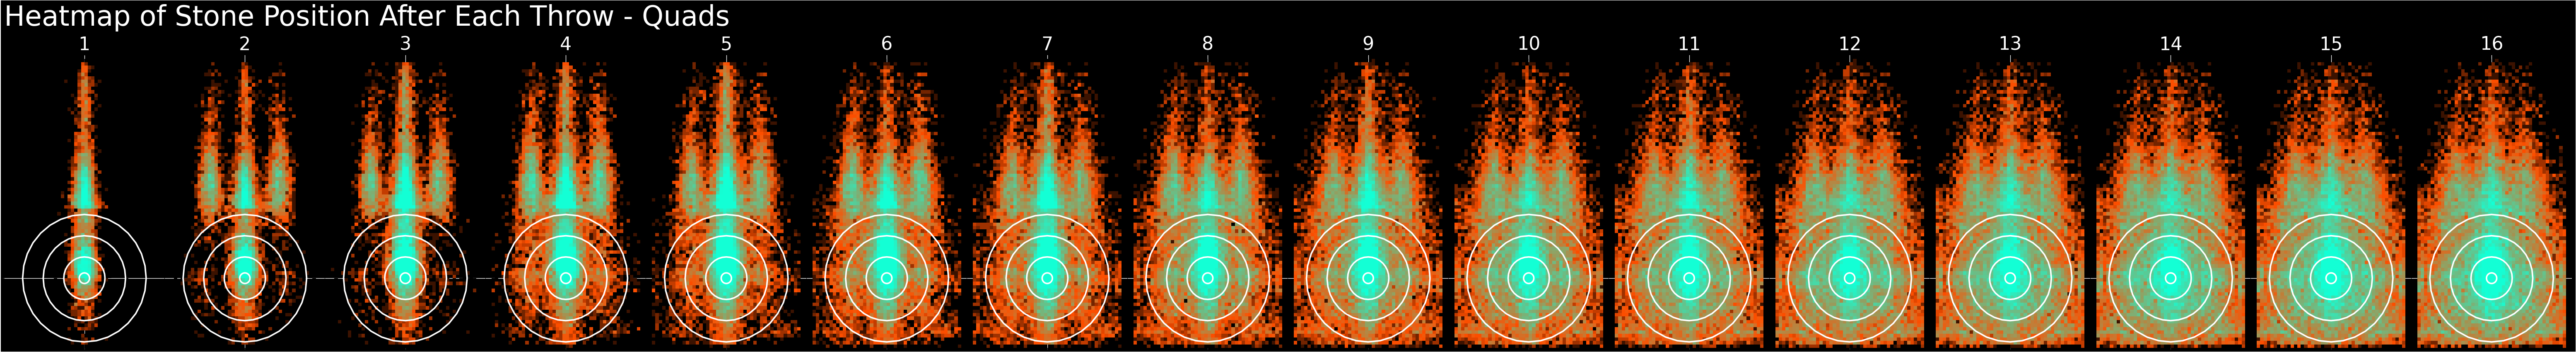

<ggplot: (716389867)>

In [63]:
g, w, h = mw_stone_heatmap((pd.concat([mens_stones, womens_stones])), title="Heatmap of Stone Position After Each Throw - Quads")
g.save(join(img_dest, 'Heatmap_Quads_pos.png'), width=(heatmap_size * w), height = (heatmap_size * h), limitsize=False)
g

#### Doub Plots

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 55 x 9.166666666666666 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Heatmap_Doub.png


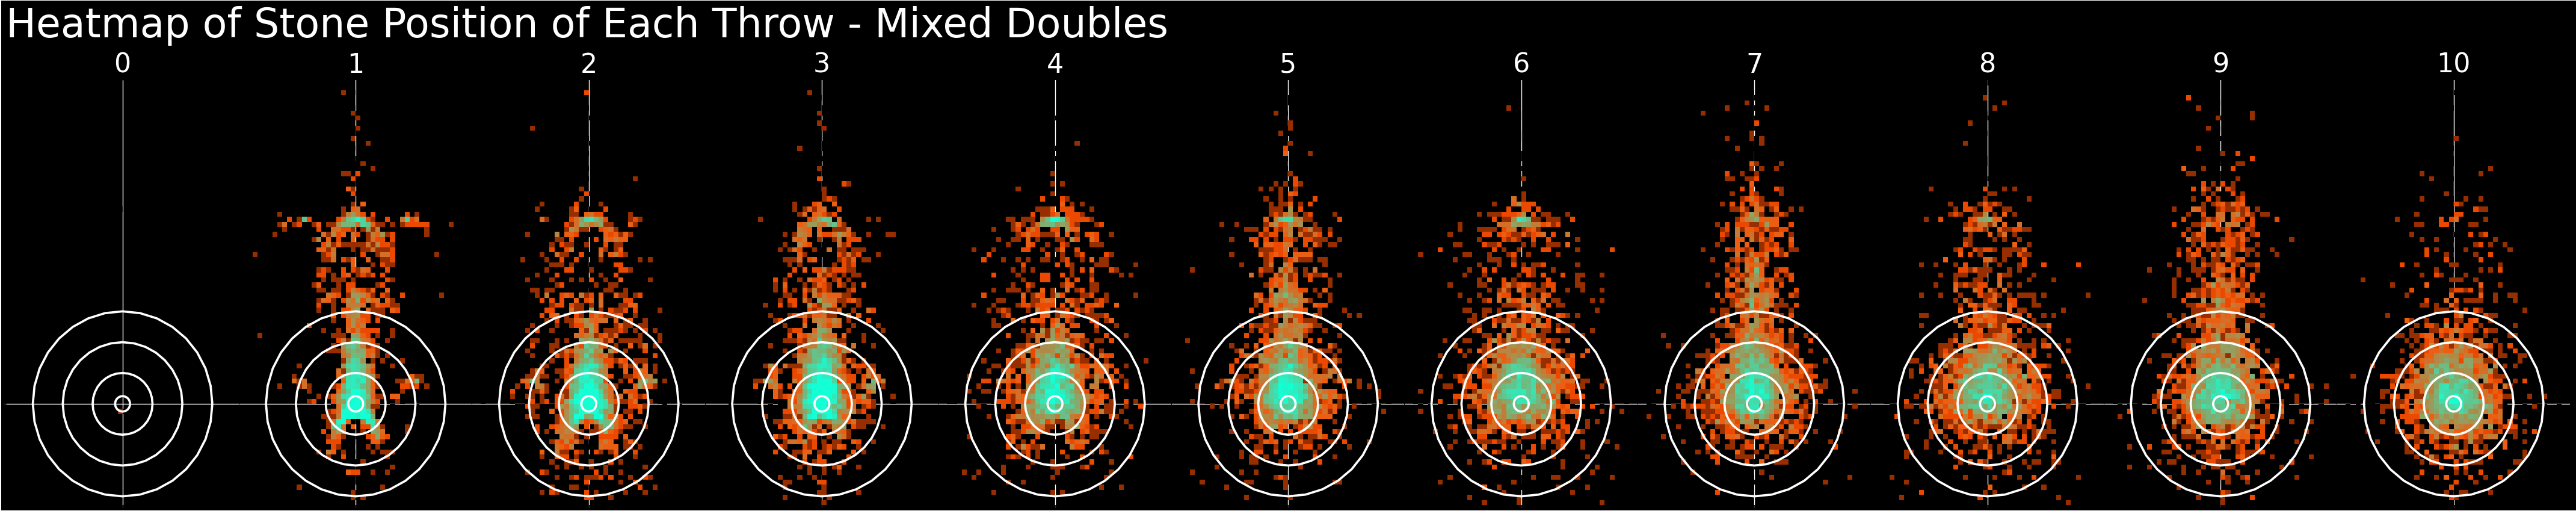

<ggplot: (708291085)>

In [64]:
g, w, h = doub_stone_heatmap(thrown_stones(doubles_stones), title='Heatmap of Stone Position of Each Throw - Mixed Doubles')
g.save(join(img_dest, 'Heatmap_Doub.png'), width=(heatmap_size * w), height = (heatmap_size * h), limitsize=False)
g

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 55 x 9.166666666666666 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Heatmap_Doub_pos.png


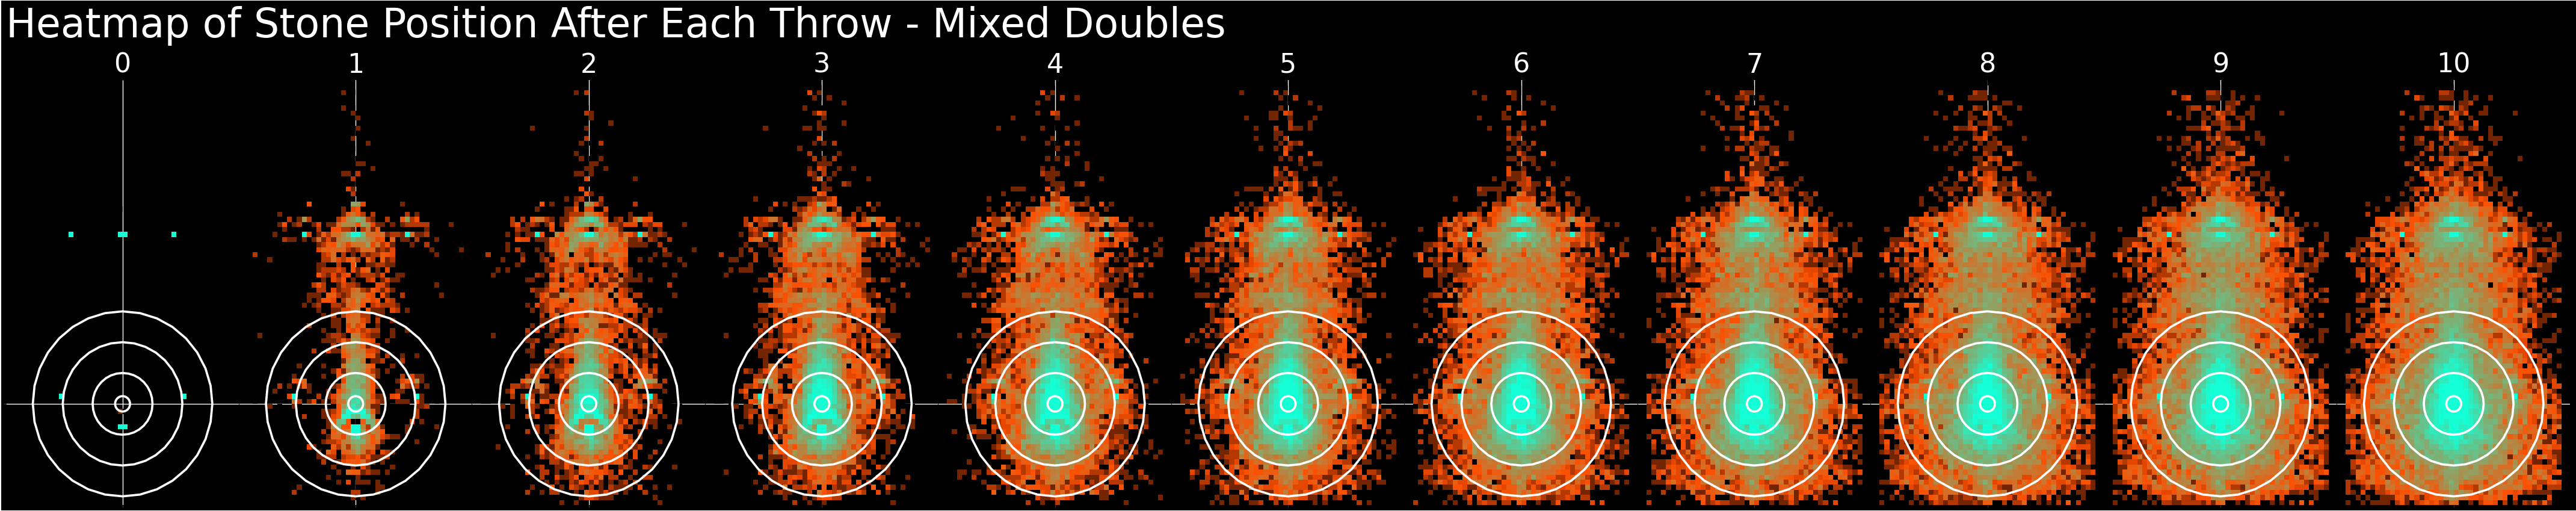

<ggplot: (708956965)>

In [65]:
g, w, h = doub_stone_heatmap((doubles_stones), title='Heatmap of Stone Position After Each Throw - Mixed Doubles')
g.save(join(img_dest, 'Heatmap_Doub_pos.png'), width=(heatmap_size * w), height = (heatmap_size * h), limitsize=False)
g

## Match Summary

### Query

In [66]:
match_summary_cmd = """
SELECT m.team_1, m.team_2, e.num, e.hammer_colour, e.direction, p.frame_num, s.x, s.y, 
       s.colour, 
       CASE WHEN s.size < 47 THEN (CASE WHEN s.colour == 'red' THEN 'pink' WHEN s.colour == 'yellow' THEN 'green' END)
            ELSE s.colour END AS label,
       s.size
FROM Stone s
RIGHT JOIN Position p
ON s.position_id = p.position_id
JOIN End e
ON p.end_id = e.end_id
JOIN Match m
ON e.match_id = m.match_id
WHERE m.match_id = ?
"""
curling_match = 1
db.execute_query(match_summary_cmd, (curling_match,))
match_summary = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'x', 'y', 'colour', 'label', 'size'])
print(match_summary.shape)
match_summary.head()

(745, 11)


team_1 team_2  end_num hammer_colour play_direction  frame_num         x  \
0    NZL    AUS        1           red           down          2  1.757926   
1    NZL    AUS        1           red           down          3  1.761611   
2    NZL    AUS        1           red           down          3  0.117932   
3    NZL    AUS        1           red           down          4  1.765297   
4    NZL    AUS        1           red           down          4  0.644941   

          y  colour  label  size  
0  1.245658     red   pink  40.0  
1  1.238288     red    red  52.0  
2 -1.370961  yellow  green  40.0  
3  1.238288     red    red  52.0  
4  0.796042     red   pink  46.0

### Plots

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 50 x 9.166666666666666 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Match_by_End.png


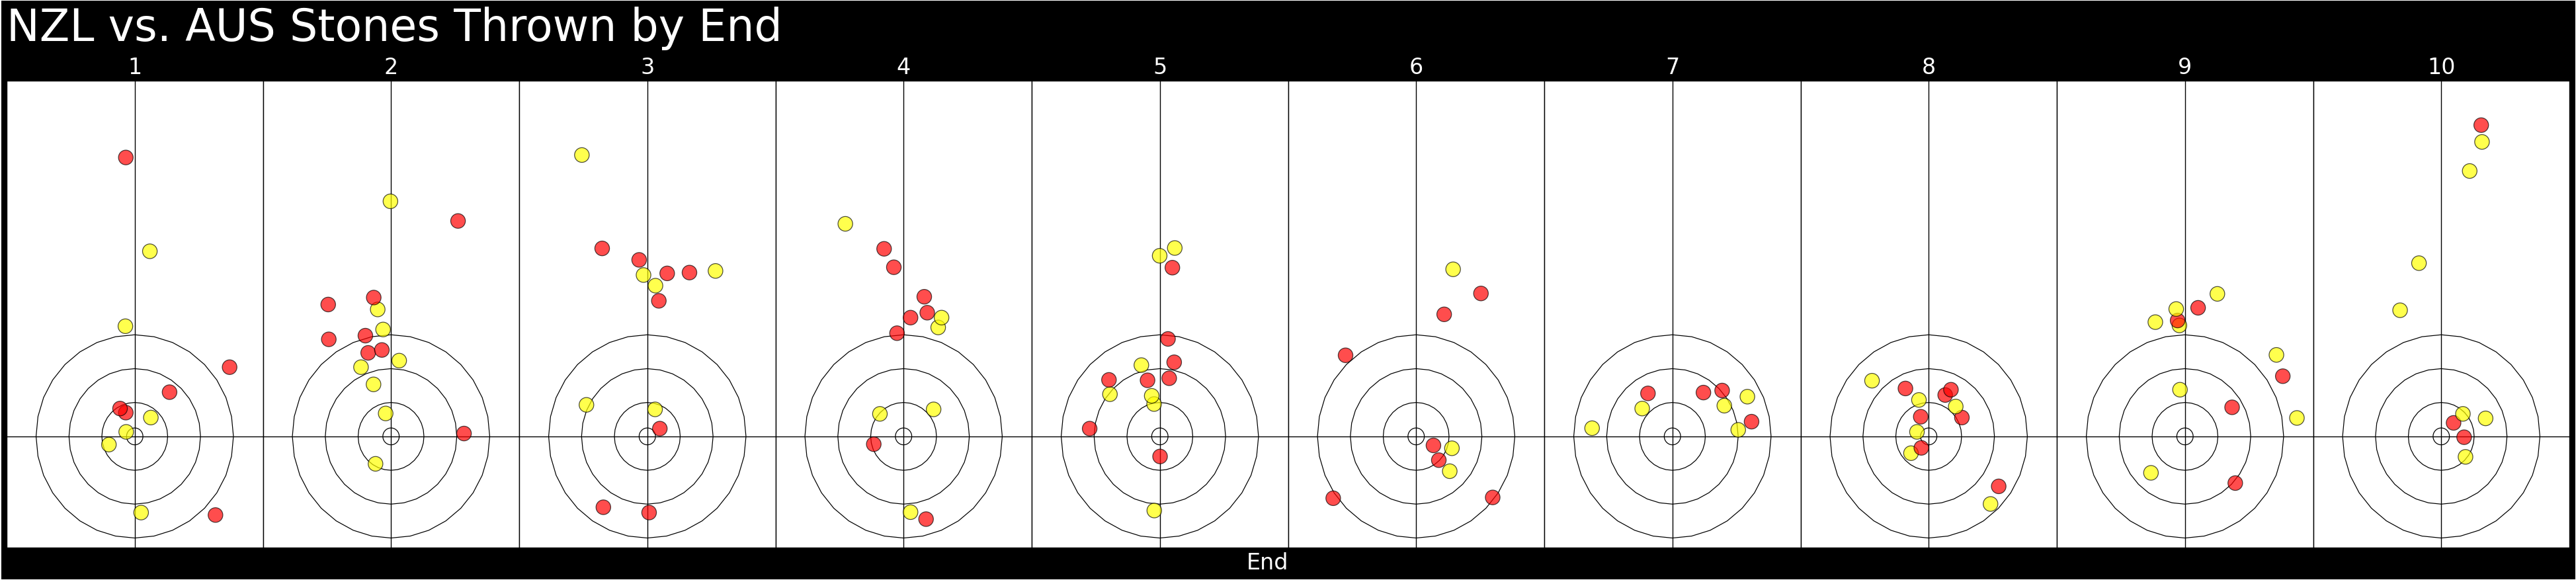

<ggplot: (686117846)>

In [67]:
size = 5
g = (gg.ggplot(thrown_stones(match_summary), gg.aes(x='x', y='y', fill='colour'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(alpha = 0.7, size=8.5)

    + gg.facet_grid('. ~ end_num')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)

    + gg.theme(figure_size=(size * (match_summary.end_num.max()), size * ((800 + 300)/(600))))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=48, ha='left'))
    + gg.theme(panel_grid=gg.element_line(colour='#000000'))
    + gg.theme(axis_text=blank, axis_title_y=blank)
    + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0, panel_border=gg.element_line(size=1))

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + pe.labels(title=f'{match_summary.team_1[0]} vs. {match_summary.team_2[0]} Stones Thrown by End', x='End', x_size=24)
    )
g.save(join(img_dest, 'Match_by_End.png'), width=(heatmap_size * (match_summary.end_num.max())), height = (heatmap_size * ((800 + 300)/(600))), dpi=300, limitsize=False)
g

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 42.5 x 45.83333333333333 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Match_Summary.png
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 18 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 18 rows containing missing values.


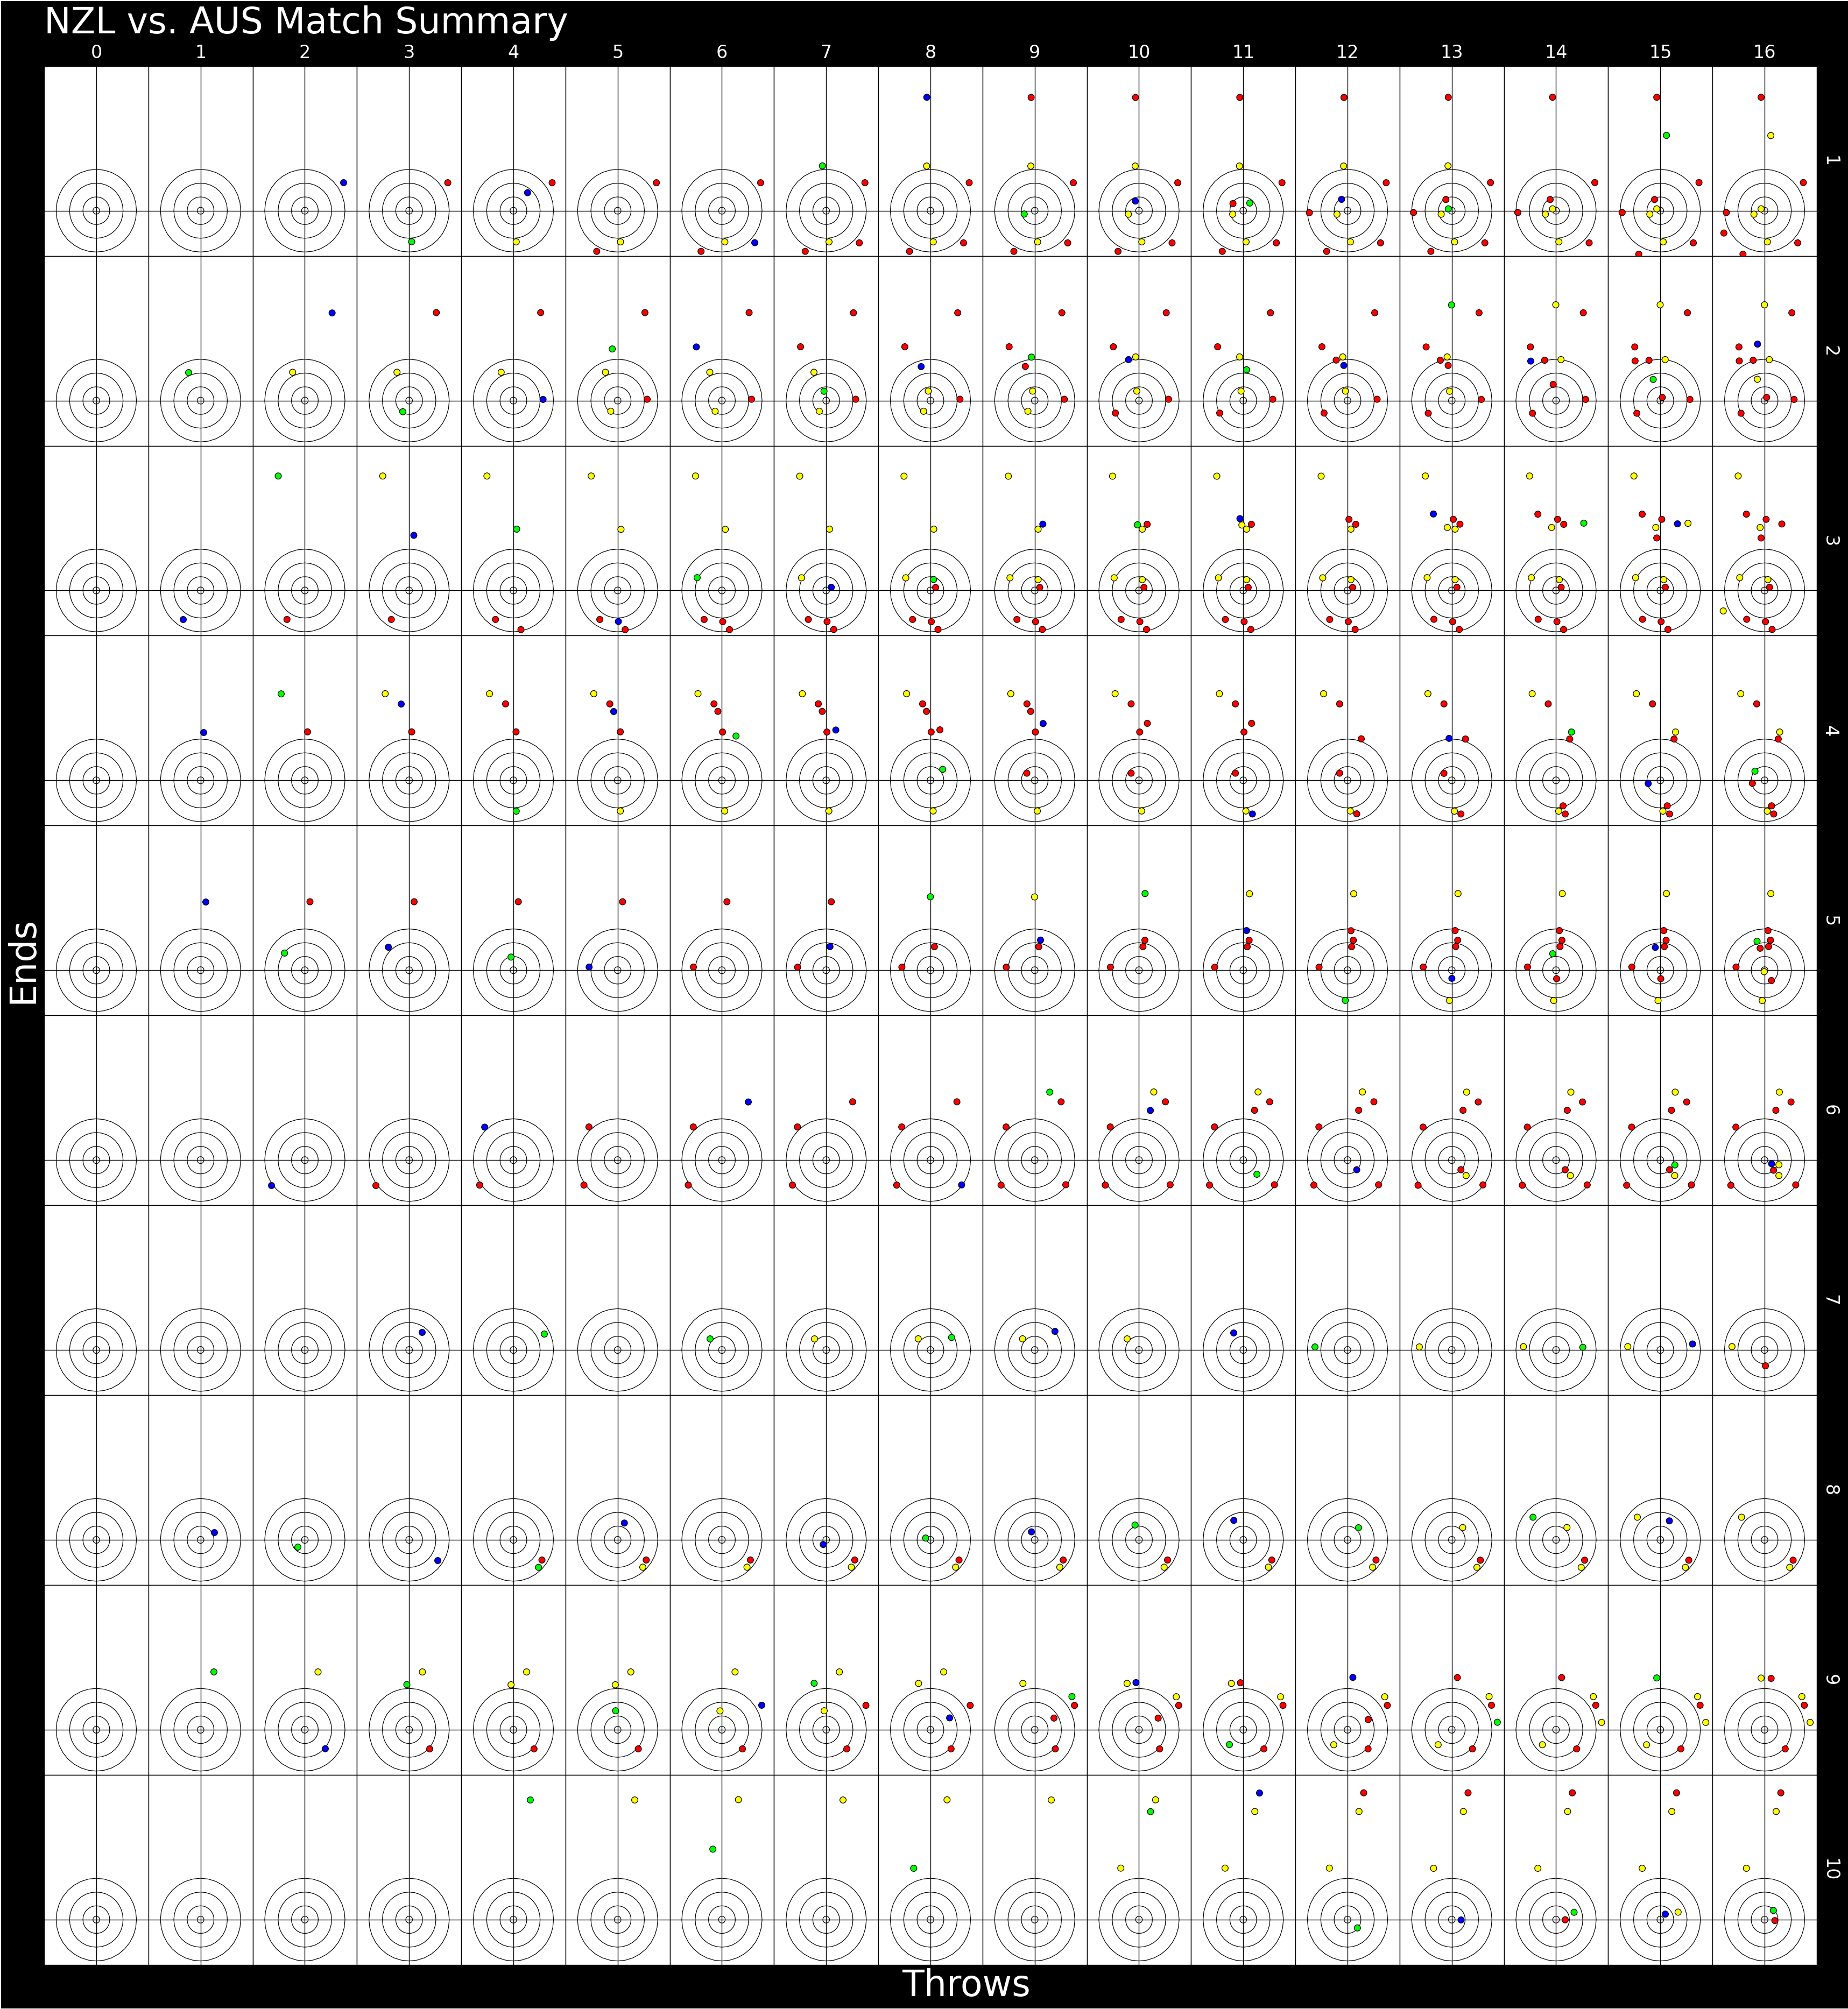

<ggplot: (715070498)>

In [68]:
size = 2.5
g = (gg.ggplot(match_summary, gg.aes(x='x', y='y', fill='label'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(size=4.25)

    + gg.facet_grid('end_num ~ frame_num', space='free')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['#00ff00', '#0000ff', '#ff0000', 'yellow'], guide=False)

    + gg.theme(figure_size=(size * (match_summary['frame_num'].max() + 1), size * (match_summary['end_num'].max()) * ((800 + 300)/(600))))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=48, ha='left'))
    + gg.theme(panel_grid=gg.element_line(colour='#000000'))
    + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing=0, panel_border=gg.element_line(size=1))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + pe.labels(title=f'{match_summary.team_1[0]} vs. {match_summary.team_2[0]} Match Summary', x='Throws', y='Ends')
    )
w, h = ((match_summary['frame_num'].max() + 1), (match_summary['end_num'].max()) * ((800 + 300)/(600)))
g.save(join(img_dest, 'Match_Summary.png'), width=(size * w), height = (size * h), limitsize=False, dpi=300)
g

### Borderline Plots

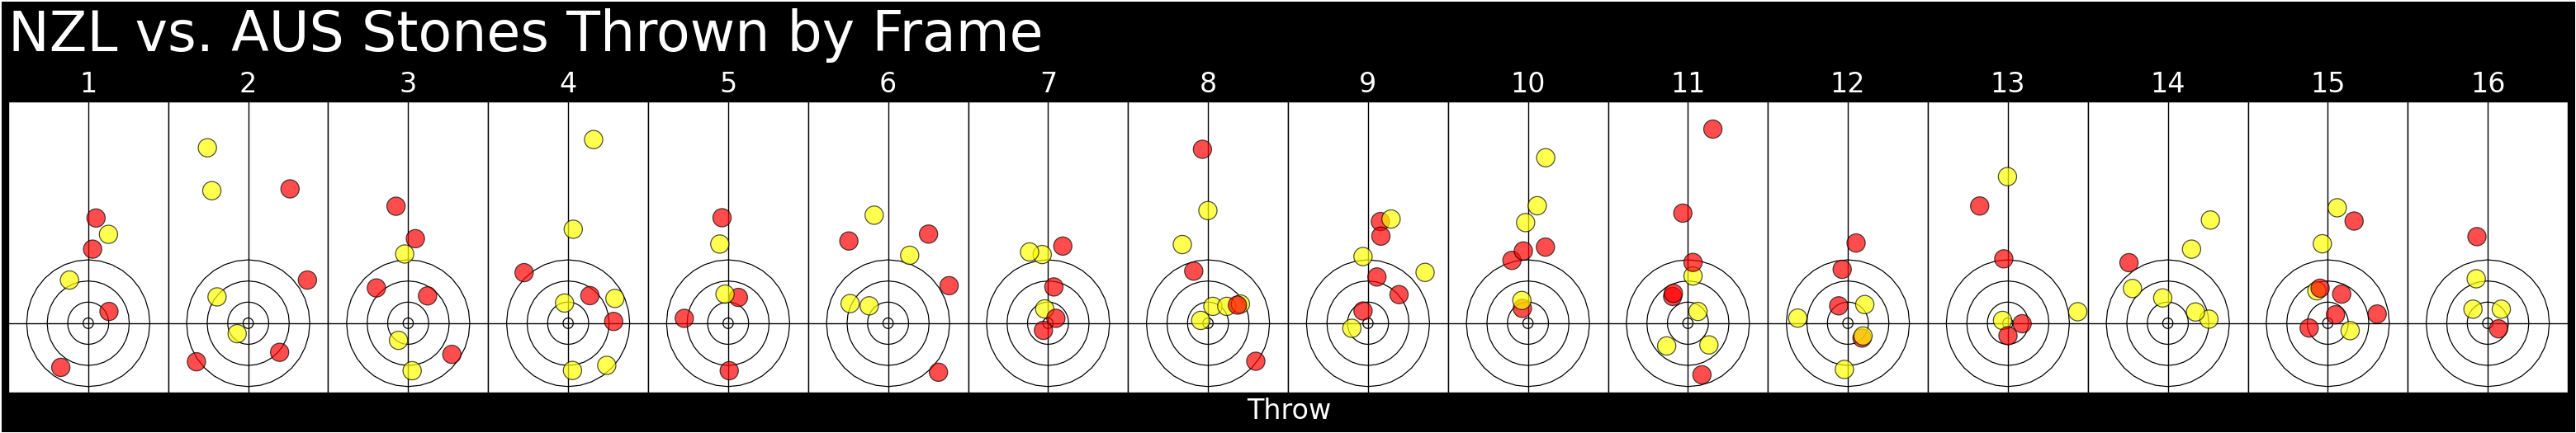

<ggplot: (708369749)>

In [69]:
(gg.ggplot(thrown_stones(match_summary), gg.aes(x='x', y='y', fill='colour'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(alpha = 0.7, size=8.5)

    + gg.facet_grid('. ~ frame_num')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)

    + gg.theme(figure_size=(size * (match_summary.frame_num.max()), size * ((800 + 300)/(600))))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=48, ha='left'))
    + gg.theme(panel_grid=gg.element_line(colour='#000000'))
    + gg.theme(axis_text=blank, axis_title_y=blank)
    + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0, panel_border=gg.element_line(size=1))

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + pe.labels(title=f'{match_summary.team_1[0]} vs. {match_summary.team_2[0]} Stones Thrown by Frame', x='Throw', x_size=24)
    )

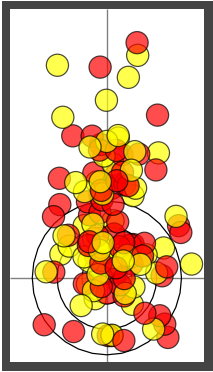

<ggplot: (725061994)>

In [70]:
(gg.ggplot(thrown_stones(match_summary), gg.aes(x='x', y='y', fill='colour'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)

    + gg.geom_point(alpha=0.7, size=8.5)

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)

    + gg.theme(figure_size=(size, size * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank, axis_title_x=blank, axis_title_y=blank, title=gg.element_text('Match Stone Locations'))
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    )

## Throw Stats

### Query

In [71]:

# Select all player throws and stone position where the stone remains on the ice and is properly recognized
player_throw_query = """
SELECT frames.abbrev, 
       frames.start_time, 
       frames.type, 
       frames.num, 
       frames.frame_num, 
       throws.name, 
       throws.team, 
       throws.sex, 
       throws.player_id,
       throws.colour, 
       throws.type, 
       throws.rating, 
       frames.x, 
       frames.y, 
       frames.coun,
       strftime('%Y', frames.start_time), 
       strftime('%m', frames.start_time)
FROM
(SELECT s.x,
        s.y,
        p.frame_num, 
        e1.num,
        p.position_id,
        e1.end_id,
        m1.type,
        MIN(s.size) as size,
        COUNT(*) as coun,
        m1.start_time,
        e2.abbrev
FROM Stone s
JOIN Position p
  ON s.position_id = p.position_id
JOIN End e1
  ON p.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
GROUP BY 5
) frames
LEFT JOIN
(SELECT t.throw_num, 
        t.colour, 
        p.player_id,
        p.name, 
        p.team, 
        p.sex,
        t.type, 
        t.rating, 
        e1.num,
        e1.end_id
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
JOIN End e1
  ON t.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
) throws
  ON frames.frame_num = throws.throw_num AND frames.end_id = throws.end_id
WHERE frames.size = 40 or frames.size = 46
"""
# Get data
db.execute_query(player_throw_query)
throws = pd.DataFrame(db.cursor.fetchall(), columns=['tournament', 'start_time', 'match_type', 'end_num', 'frame_num', 'player', 'team', 'sex', 'player_id', 'colour', 'throw_type', 'rating', 'x', 'y', 'stone_count', 'year', 'month']).dropna()

# Format
throws['start_time'] = pd.to_datetime(throws.start_time)
for col in ['tournament', 'match_type', 'team', 'sex', 'colour', 'throw_type']:
  throws[col] = pd.Categorical(throws[col])

throws['nationality'] = throws.team.apply(lambda x: x[:3])

throws = throws.astype({'player_id': 'int32', 'rating': 'int32', 'year': 'int32', 'month': 'int32'})

print(throws.shape)
throws.head()

(207720, 18)


tournament          start_time    match_type  end_num  frame_num  \
0  CUR_PACC2017B 2017-11-04 19:00:00  Womens_Teams        1          2   
1  CUR_PACC2017B 2017-11-04 19:00:00  Womens_Teams        1          3   
2  CUR_PACC2017B 2017-11-04 19:00:00  Womens_Teams        1          4   
3  CUR_PACC2017B 2017-11-04 19:00:00  Womens_Teams        1          6   
4  CUR_PACC2017B 2017-11-04 19:00:00  Womens_Teams        1          7   

               player team sex  player_id  colour throw_type  rating  \
0          THOMPSON H  NZL   f          2     red      Front       2   
1  FREDERICKS ARMSTR.  AUS   f          1  yellow       Draw       3   
2          THOMPSON H  NZL   f          2     red       Draw       4   
3        JEYARANJAN T  NZL   f          4     red       Draw       0   
4            POWELL A  AUS   f          3  yellow       Draw       0   

          x         y  stone_count  year  month nationality  
0  1.757926  1.245658            1  2017     11         NZL  
1  0.117932 -1.370961            2  2017     11         AUS  
2  0.644941  0.796042            3  2017     11         NZL  
3  1.496264 -1.415186            4  2017     11         NZL  
4 -0.173213  1.982734            5  2017     11         AUS

In [72]:
def remove_misread(df: pd.DataFrame) -> pd.DataFrame:
    return df.query('rating != -1')

throw_classes = {'Clearing': 'Clear/TO', 'Double Take-out': 'Clear/TO', 'Draw': 'Draw', 'Freeze': 'Guard', 'Front': 'Guard', 'Guard': 'Guard', 'Hit and Roll': 'Clear/TO', 
          'Promotion Take-out': 'Clear/TO', 'Raise': 'Misc', 'Take-out': 'Clear/TO', 'Through': 'Through', 'Wick / Soft Peeling': 'Misc', 'no statistics': 'No Stats'}

### Plots

#### Utils

In [73]:
player_of_interest = 237
def select_player(df: pd.DataFrame, player_id: int=0) -> pd.DataFrame:
    return df.query('player_id == @player_id')

#### Player Throw Areas

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/scales/scale_size.py:48: PlotnineWarning: Using size for a discrete variable is not advised.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_size_discrete could not recognise parameter `values`
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 7.333333333333333 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Player_Zones.png


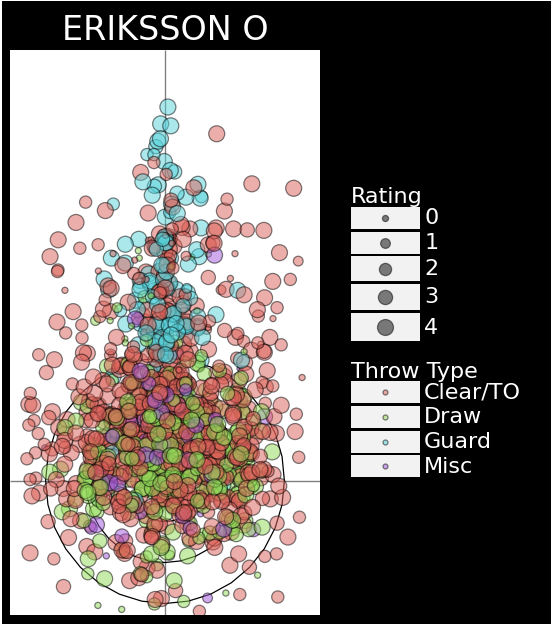

<ggplot: (725438651)>

In [74]:
size=4
throws['throw_class'] = throws.throw_type.apply(lambda x: throw_classes[x])
g = (gg.ggplot(remove_misread(select_player(throws, 237)), gg.aes(x='x', y='y', fill='factor(throw_class)', size='factor(rating)'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)

    + gg.geom_point(alpha=0.5)

    + gg.facet_grid('. ~ player')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_size_discrete(values=[2, 4, 6, 8, 10])

    + gg.theme(figure_size=(size, size * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=48, ha='left'))
    + gg.theme(axis_text=blank, axis_title=blank, legend_text=gg.element_text(size=16), legend_title=gg.element_text(size=16), legend_background=gg.element_rect(fill='#000000'), legend_key_width=50)
    + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0)

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + gg.labs(size='Rating', fill='Throw Type')
    )
w, h =  (1, ((800 + 300)/(600)))
g.save(join(img_dest, 'Player_Zones.png'), width=(size * w), height = (size * h), limitsize=False, dpi=300)
g

#### Throw Type Heatmap

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 52 x 7.333333333333333 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Shot_Type_Heatmap.png


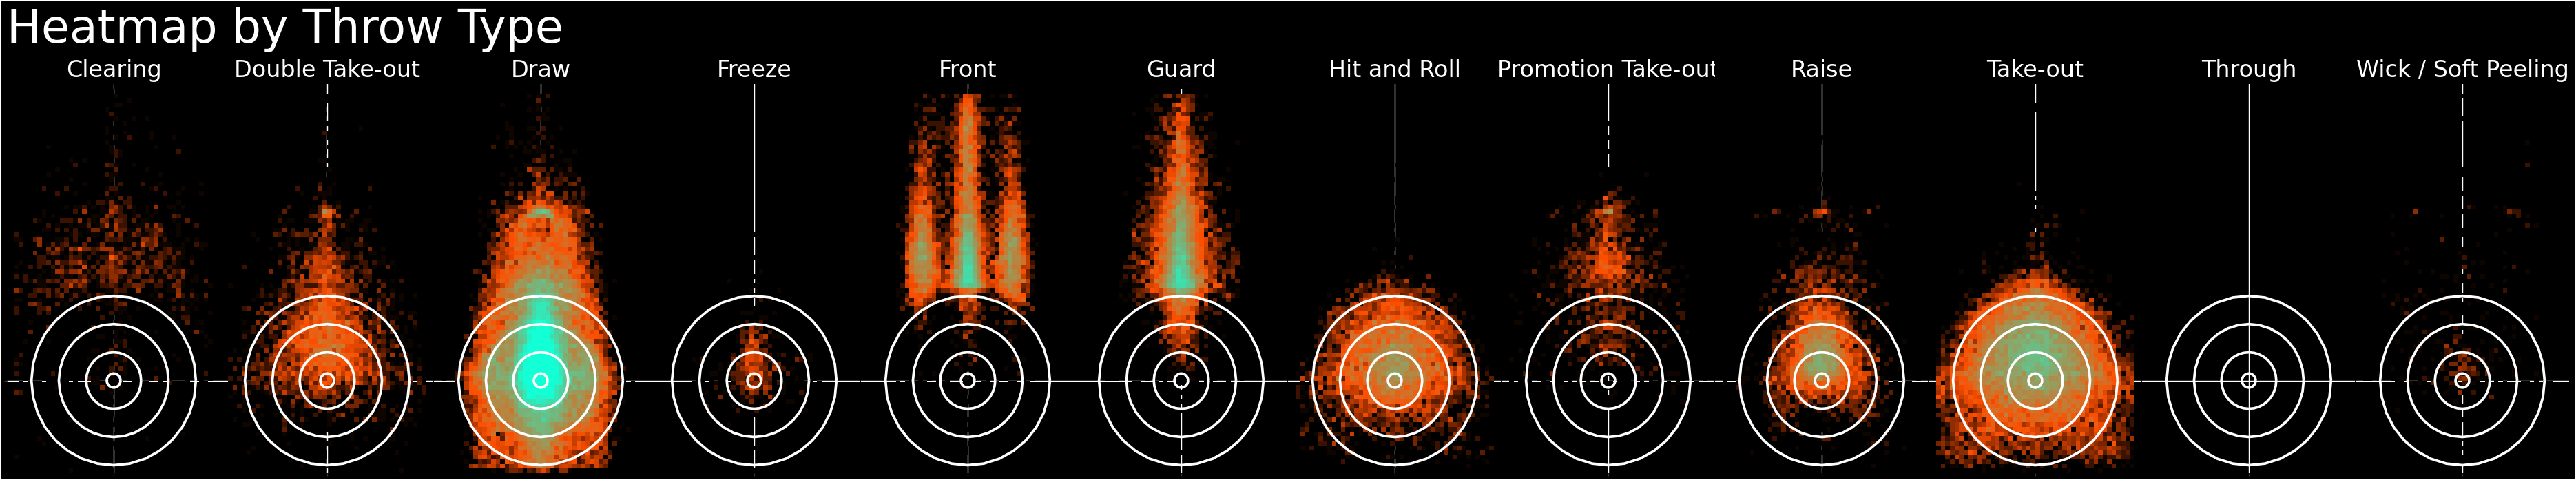

<ggplot: (714089250)>

In [75]:
g = ((gg.ggplot(throws.query('throw_type != "no statistics"'), gg.aes(x='x', y='y'))
    + gg.geom_bin_2d(binwidth=0.1)
    + gg.facet_grid('. ~ throw_type')
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour=circle_colour, size=circle_size)

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    # + gg.scale_fill_gradientn(colors=['#dddddd', '#888888', '#444444', '#000000', '#000000'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#000000', '#880000', '#d64302', '#ff4f00', '#ff4f00'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#ff4f00', '#ffd000', '#ffd000'], values=[0, 0.08, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#ffffff', '#ff4f00', '#aa0000', '#aa0000'], values=[0, 0.08, 0.3, 1], guide=False)
    + gg.scale_fill_gradientn(colors=['#000000', '#000000', '#ff4f00', '#13FFD5', '#13FFD5'], values=[0, 0.15, 0.4, 0.8, 1], guide=False, trans='log')

    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=48, ha='left'))
    + gg.theme(axis_text=blank, axis_title=blank)
    + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0)
    + gg.theme(panel_border=gg.element_line(size=2))
    + gg.theme(figure_size=(size * (len(throws.throw_type.value_counts()) - 1), size * ((800 + 300)/(600))))

    + pe.background_colour(panel_colour='#000000', plot_colour='#000000')
    + pe.remove_ticks(minor=True)
    + pe.labels(title='Heatmap by Throw Type')
    ))
w, h = (size * len(throws.throw_type.value_counts()), size * ((800 + 300)/(600)))
g.save(join(img_dest, 'Shot_Type_Heatmap.png'), width=w, height = h, limitsize=False, dpi=300)
g

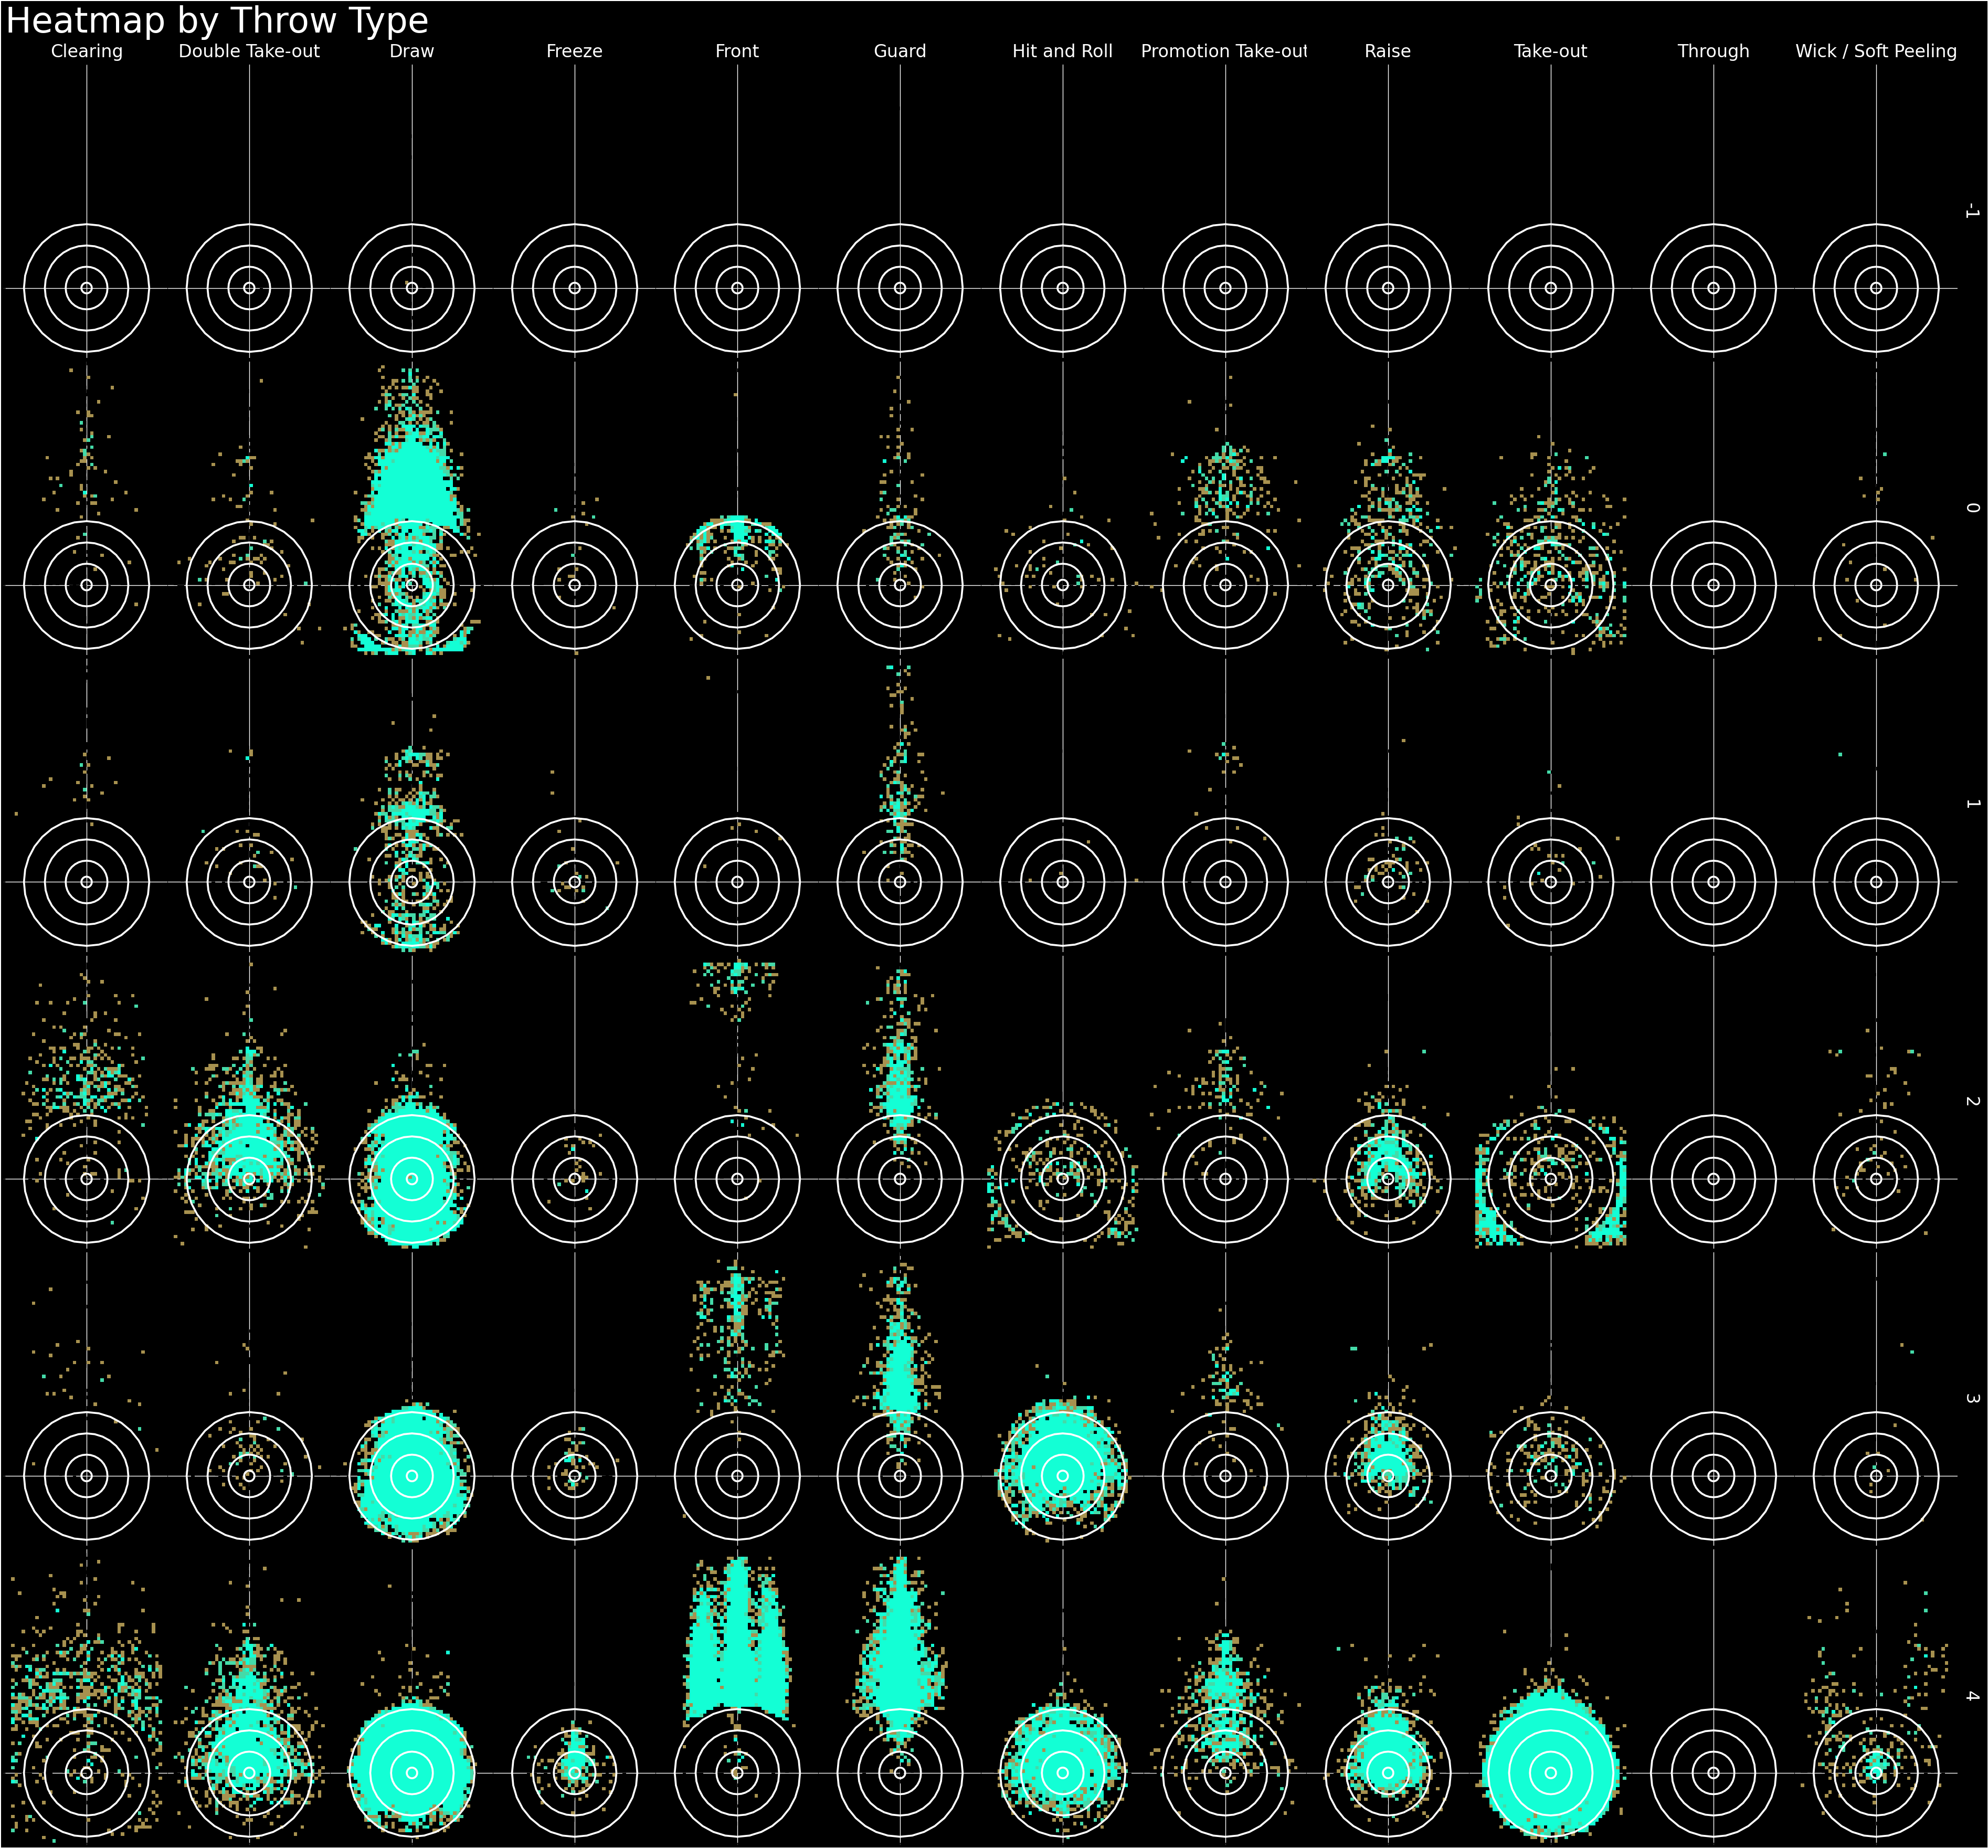

<ggplot: (708711527)>

In [76]:
g = ((gg.ggplot(throws.query('throw_type != "no statistics"'), gg.aes(x='x', y='y'))
    + gg.geom_bin_2d(binwidth=0.1)
    + gg.facet_grid('rating ~ throw_type')
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour=circle_colour, size=circle_size)

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    # + gg.scale_fill_gradientn(colors=['#dddddd', '#888888', '#444444', '#000000', '#000000'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#000000', '#880000', '#d64302', '#ff4f00', '#ff4f00'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#ff4f00', '#ffd000', '#ffd000'], values=[0, 0.08, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#ffffff', '#ff4f00', '#aa0000', '#aa0000'], values=[0, 0.08, 0.3, 1], guide=False)
    + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#13FFD5', '#13FFD5'], values=[0, 0.05, 0.2, 1], guide=False, trans='log')

    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=48, ha='left'))
    + gg.theme(axis_text=blank, axis_title=blank)
    + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0)
    + gg.theme(panel_border=gg.element_line(size=2))
    + gg.theme(figure_size=(size * (len(throws.throw_type.value_counts()) - 1), size * ((800 + 300)/(600)) * 6))

    + pe.background_colour(panel_colour='#000000', plot_colour='#000000')
    + pe.remove_ticks(minor=True)
    + pe.labels(title='Heatmap by Throw Type')
    ))
w, h = (size * len(throws.throw_type.value_counts()), size * ((800 + 300)/(600)))
# g.save(join(img_dest, 'Shot_Type_Heatmap.png'), width=w, height = h * 5, limitsize=False, dpi=300)
g

#### Shot Class Heatmap

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 52 x 7.333333333333333 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Shot_Class_Heatmap.png


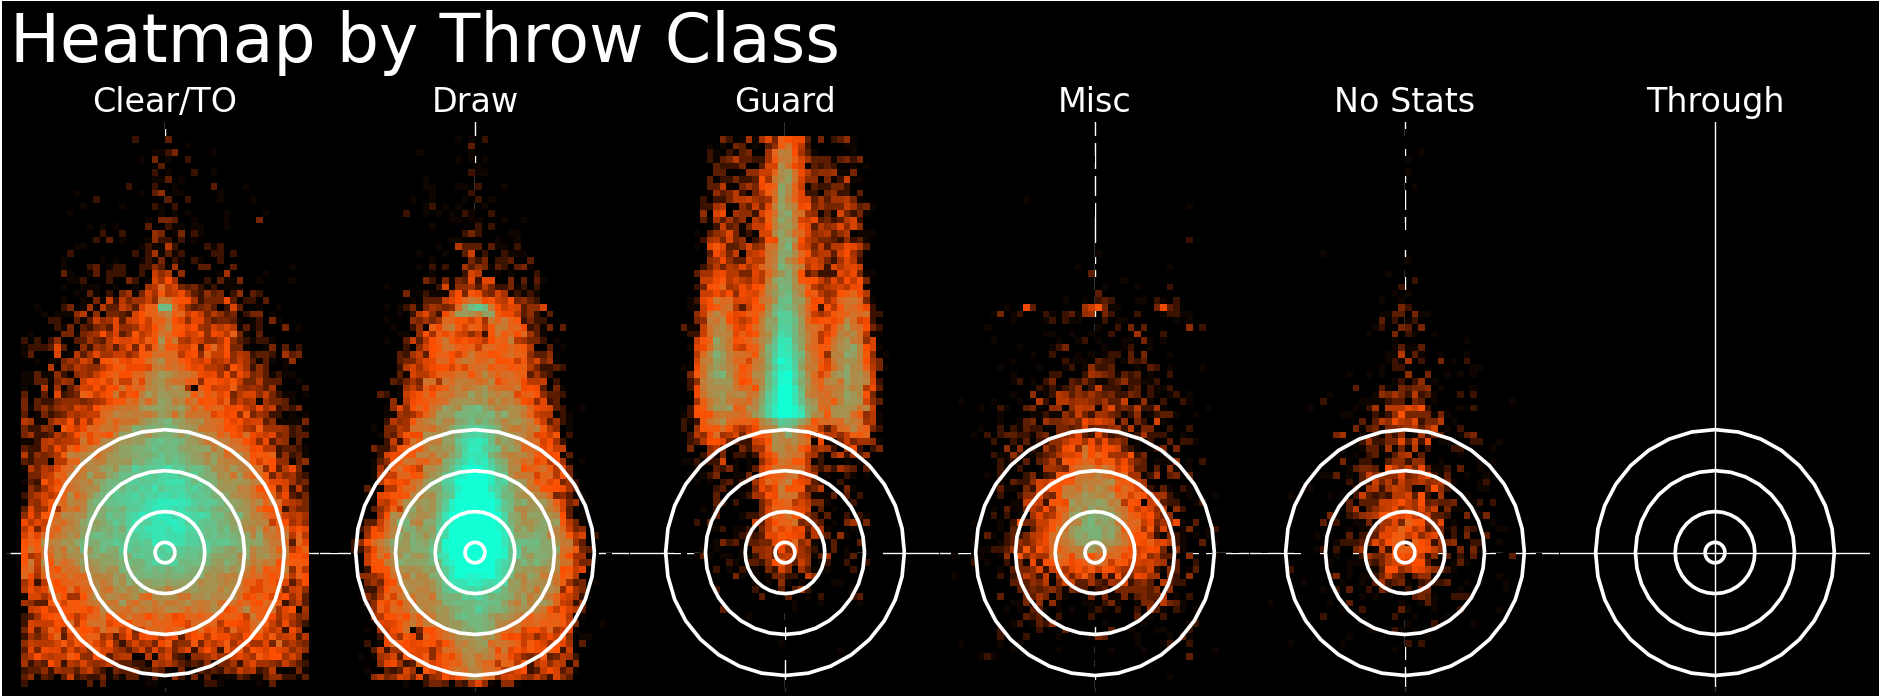

<ggplot: (727660608)>

In [77]:
g = ((gg.ggplot(throws, gg.aes(x='x', y='y'))
    + gg.geom_bin_2d(binwidth=0.1)
    + gg.facet_grid('. ~ throw_class')
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour=circle_colour, size=circle_size)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour=circle_colour, size=circle_size)

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    # + gg.scale_fill_gradientn(colors=['#dddddd', '#888888', '#444444', '#000000', '#000000'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#000000', '#880000', '#d64302', '#ff4f00', '#ff4f00'], values=[0, 0.01, 0.15, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#ff4f00', '#ffd000', '#ffd000'], values=[0, 0.08, 0.3, 1], guide=False)
    # + gg.scale_fill_gradientn(colors=['#ffffff', '#ff4f00', '#aa0000', '#aa0000'], values=[0, 0.08, 0.3, 1], guide=False)
    + gg.scale_fill_gradientn(colors=['#000000', '#000000', '#ff4f00', '#13FFD5', '#13FFD5'], values=[0, 0.15, 0.4, 0.8, 1], guide=False, trans='log')

    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=48, ha='left'))
    + gg.theme(axis_text=blank, axis_title=blank)
    + gg.theme(strip_background=gg.element_rect(fill='#000000'), panel_spacing_x=0)
    + gg.theme(panel_border=gg.element_line(size=2))
    + gg.theme(figure_size=(size * len(throws.throw_class.value_counts()), size * ((800 + 300)/(600))))

    + pe.background_colour(panel_colour='#000000', plot_colour='#000000')
    + pe.remove_ticks(minor=True)
    + pe.labels(title='Heatmap by Throw Class')
    ))
w, h = (size * len(throws.throw_type.value_counts()), size * ((800 + 300)/(600)))
g.save(join(img_dest, 'Shot_Class_Heatmap.png'), width=w, height = h, limitsize=False, dpi=300)
g

#### Distribution by Shot Type

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 15 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Shot_Type_Distribution.png
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid valu

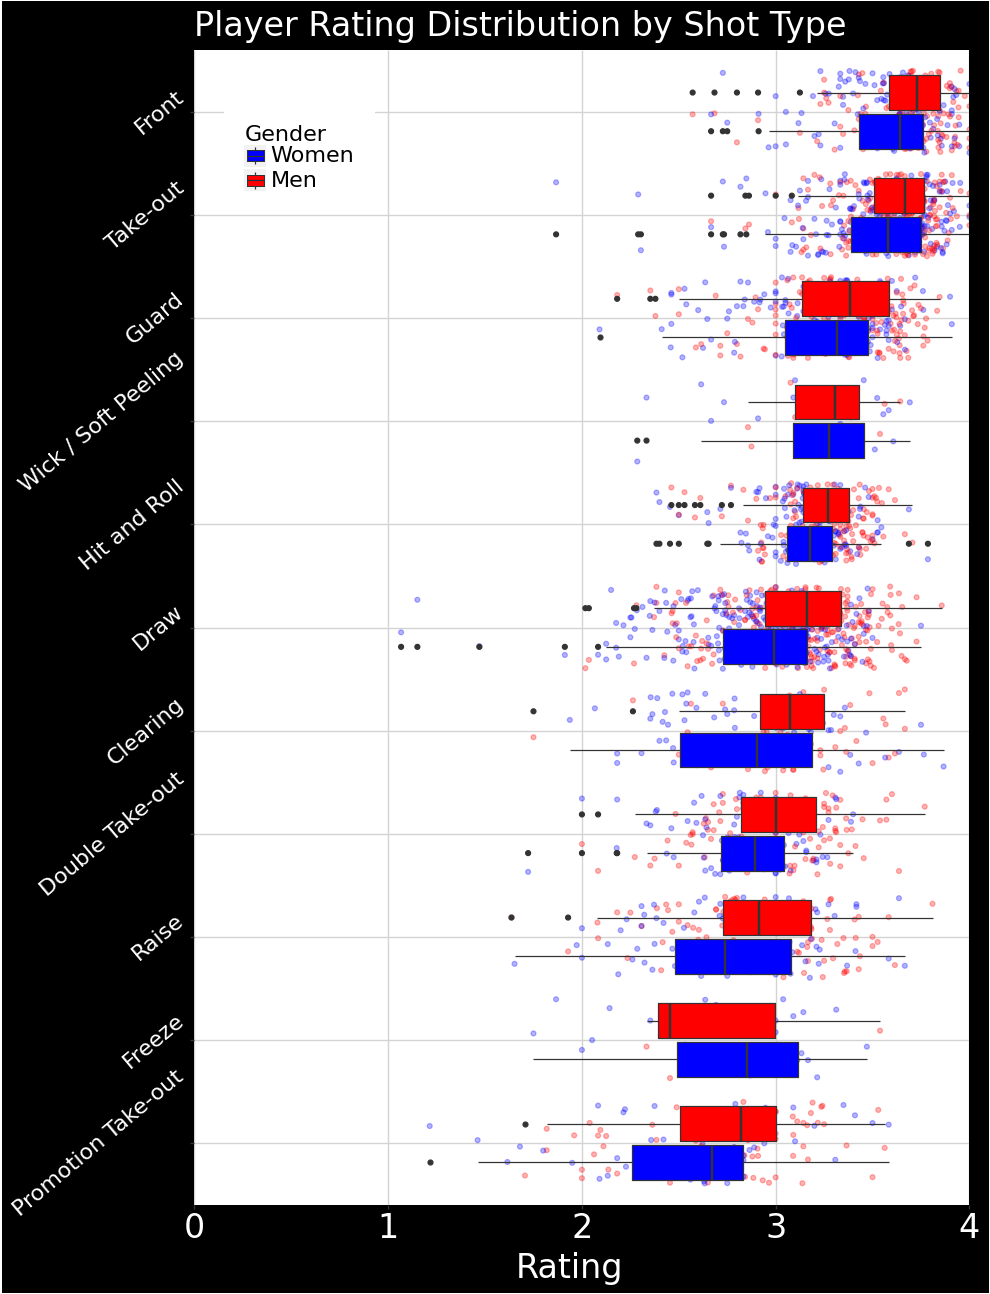

<ggplot: (725212757)>

In [78]:
throw_ratings = remove_misread(throws.query('(throw_type != "no statistics") & (sex in ["m", "f"])')).groupby(['throw_type', 'player', 'sex']).agg({'rating':['mean', 'count']}).reset_index().dropna()
throw_ratings.columns = ['_'.join(x).strip('_') for x in throw_ratings.columns]
throw_ratings = throw_ratings.query('(rating_count > 10)').sort_values(['throw_type', 'rating_mean'], ascending=False).reset_index(drop=True)
throw_ratings['sex'] = throw_ratings['sex'].cat.remove_unused_categories()
g = (gg.ggplot(throw_ratings, gg.aes(y='rating_mean', x='reorder(throw_type, rating_mean)', fill='sex')) 
    + gg.geom_jitter(gg.aes(colour='sex'), alpha=0.3) 
    + gg.geom_boxplot()

    + gg.coord_flip()

    + gg.scale_fill_manual(values=['blue', 'red'], labels=['Women', 'Men'])
    + gg.scale_colour_manual(values=['blue', 'red'], guide=False)
    + gg.scale_y_continuous(limits=(0, 4), expand=(0, 0))

    + gg.theme(figure_size=(10, 15))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text_y=gg.element_text(size=16, angle=40), axis_title_x=gg.element_text(ha='center'))
    + gg.theme(axis_title_y=blank, legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.23, 0.81), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.labels(title='Player Rating Distribution by Shot Type')
    + gg.labs(fill='Gender', y='Rating')
    )
g.save(join(img_dest, 'Shot_Type_Distribution.png'), width=(10), height = (15), limitsize=False, dpi=300)
g

#### Distribution by Shot Class

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5.5 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Shot_Class_Distribution.png
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_jitter : Removed 2 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_jitter : Removed 2 rows containing missing values.


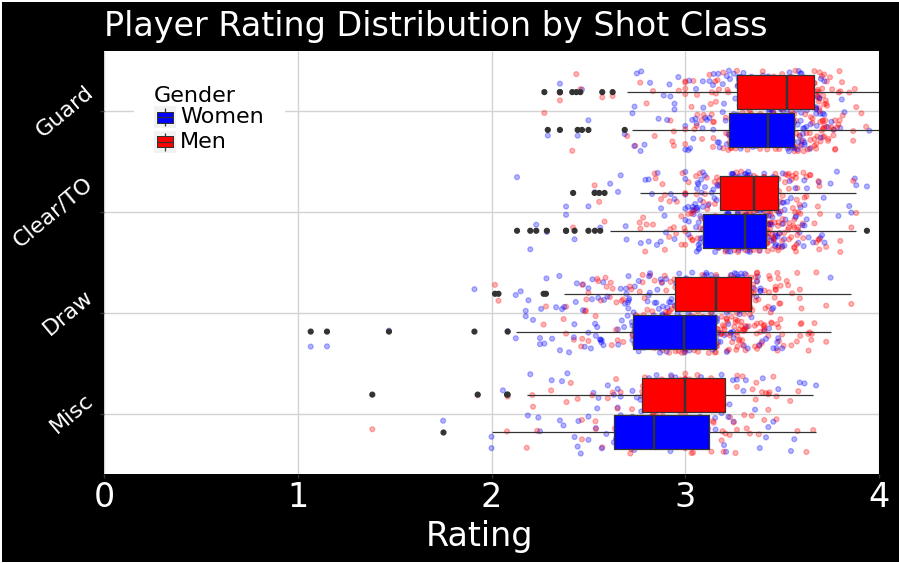

<ggplot: (718523591)>

In [79]:
throw_ratings = remove_misread(throws.query('(throw_type != "no statistics") & (sex in ["m", "f"])')).groupby(['throw_class', 'player', 'sex']).agg({'rating':['mean', 'count']}).reset_index().dropna()
throw_ratings.columns = ['_'.join(x).strip('_') for x in throw_ratings.columns]
throw_ratings = throw_ratings.query('(rating_count > 10)').sort_values(['throw_class', 'rating_mean'], ascending=False).reset_index(drop=True)
# throw_ratings['throw_class'] = throw_ratings.throw_type.apply(lambda x: throw_classes[x])
throw_ratings['sex'] = throw_ratings['sex'].cat.remove_unused_categories()
g = (gg.ggplot(throw_ratings, gg.aes(y='rating_mean', x='reorder(throw_class, rating_mean)', fill='sex')) 
    + gg.geom_jitter(gg.aes(colour='sex'), alpha=0.3) 
    + gg.geom_boxplot()

    + gg.coord_flip()

    + gg.scale_fill_manual(values=['blue', 'red'], labels=['Women', 'Men'])
    + gg.scale_colour_manual(values=['blue', 'red'], guide=False)
    + gg.scale_y_continuous(limits=(0, 4), expand=(0, 0))

    + gg.theme(figure_size=(10, 5.5))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text_y=gg.element_text(size=16, angle=40), axis_title_x=gg.element_text(ha='center'))
    + gg.theme(axis_title_y=blank, legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.23, 0.76), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.labels(title='Player Rating Distribution by Shot Class')
    + gg.labs(fill='Gender', y='Rating')
    )
g.save(join(img_dest, 'Shot_Class_Distribution.png'), width=(10), height=(5.5), limitsize=False, dpi=300)
g

#### Single Player Rating Table

In [80]:
select_player(throws, 535).groupby(['throw_type']).agg(['mean', 'count']).sort_values(('rating', 'mean'), ascending=False)[[('rating', 'mean'), ('rating', 'count')]]

/var/folders/zz/z3rhbf4x4hdb8gwyxnpw92_40000gn/T/ipykernel_63822/3190435542.py:1: FutureWarning: ['tournament', 'match_type', 'player', 'team', 'sex', 'colour', 'nationality', 'throw_class'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


rating      
                         mean count
throw_type                         
Clearing             4.000000     5
Front                4.000000     4
Take-out             3.758065   124
Guard                3.608696    23
Draw                 3.591549   142
Hit and Roll         3.500000    30
Raise                3.296296    27
Promotion Take-out   3.111111    18
Double Take-out      3.074074    27
Freeze               2.500000     2
Through                   NaN     0
Wick / Soft Peeling       NaN     0
no statistics             NaN     0

#### Rating by Throw Count

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Rating_by_Throw_Number.png


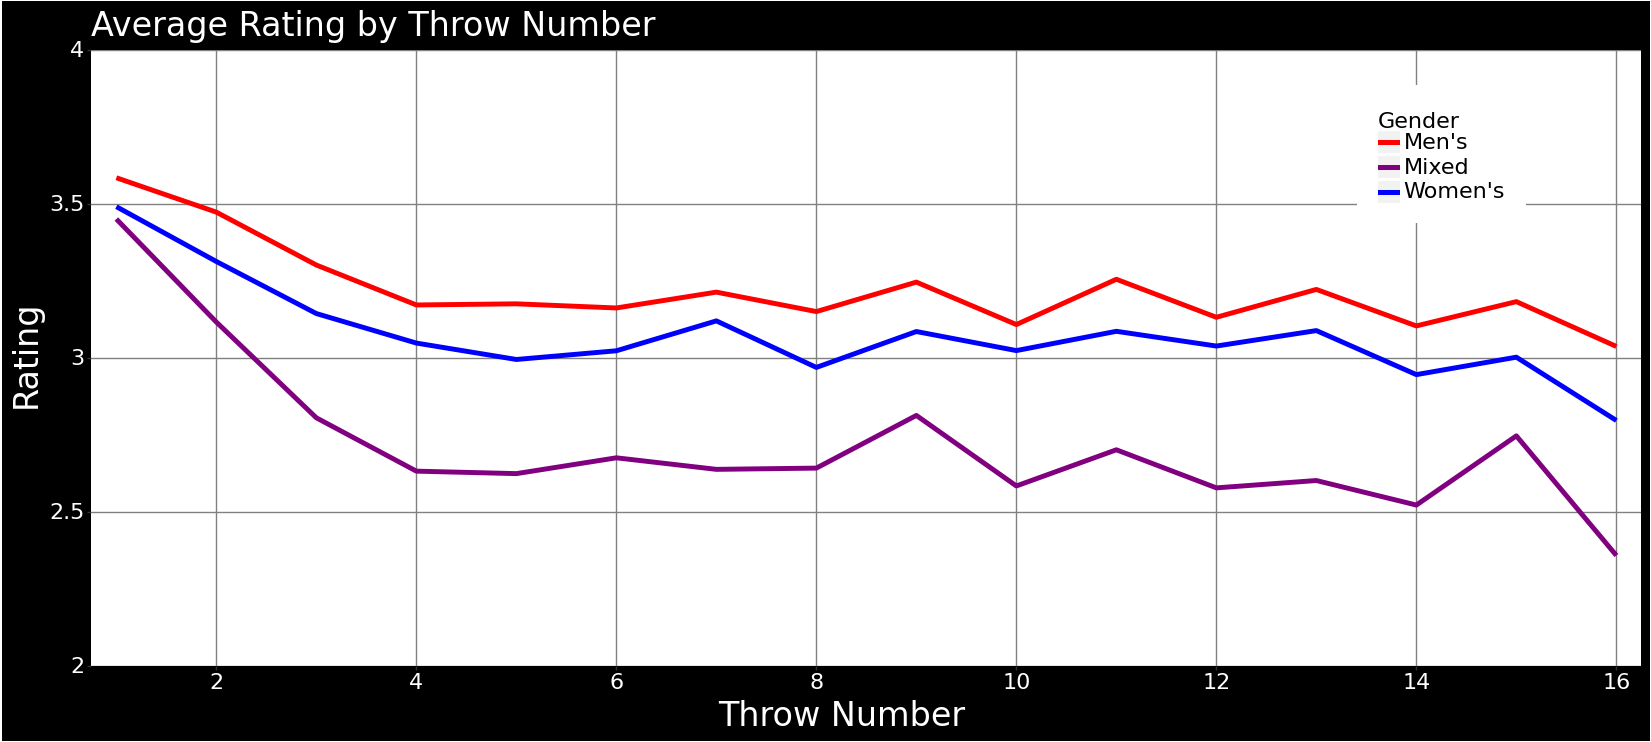

<ggplot: (718238986)>

In [81]:
throws_type_count = throws.groupby(['frame_num', 'match_type']).agg({'rating': 'mean'}).reset_index().query('match_type != "Mixed_Doubles"')
throws_type_count['match_type'] = throws_type_count['match_type'].cat.remove_unused_categories()
g = (gg.ggplot(throws_type_count, gg.aes(x='frame_num', y='rating', colour='match_type')) 
    + gg.geom_line(size=2)

    + gg.scale_y_continuous(limits=(2, 4), expand=(0, 0))
    + gg.scale_x_continuous(limits=(1, 16), expand=(0, 0.25), breaks=lambda x: [int(x) for x in range(0, int(x[1]) + 1, 2)])
    + gg.scale_colour_manual(values=['red', 'purple', 'blue'] , labels=["Men's", "Mixed", "Women's"])

    + gg.theme(figure_size=(20, 8))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=16))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.8, 0.75), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='gray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.labels(title='Average Rating by Throw Number')
    + gg.labs(colour='Gender', x='Throw Number', y='Rating')
    )
g.save(join(img_dest, 'Rating_by_Throw_Number.png'), width=(20), height=(8), limitsize=False, dpi=300)
g

#### Rating by Stone Count

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Rating_by_Stone_Count.png


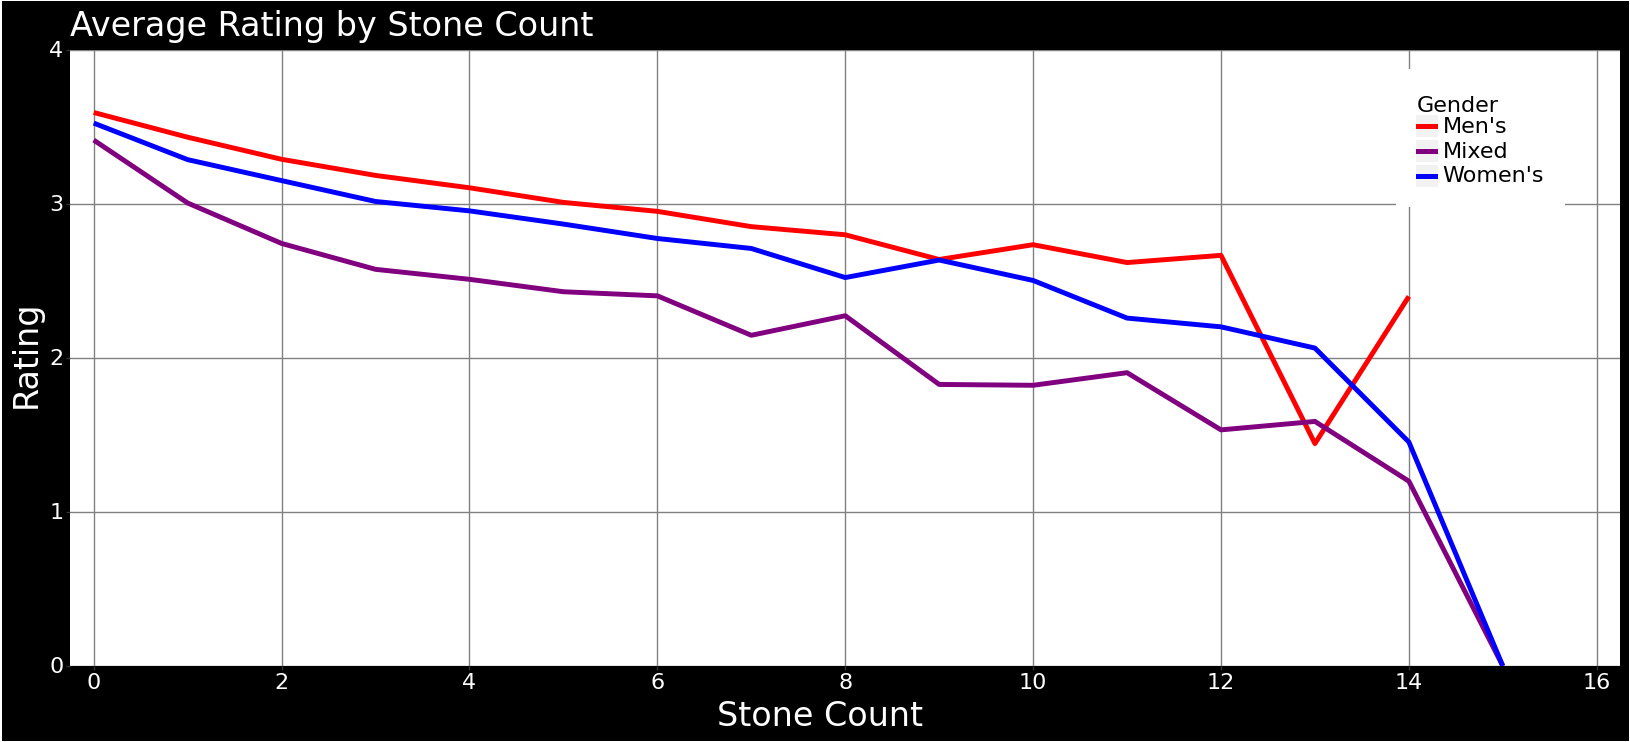

<ggplot: (713558977)>

In [82]:
throw_class_count = throws.query('match_type != "Mixed_Doubles"').groupby(['stone_count', 'match_type']).agg({'rating': 'mean'}).reset_index().query('match_type != "Mixed_Doubles"')
throw_class_count['match_type'] = throw_class_count['match_type'].cat.remove_unused_categories()
g = (gg.ggplot(throw_class_count, gg.aes(x='stone_count - 1', y='rating', colour='match_type')) 
    + gg.geom_line(size=2)

    + gg.scale_y_continuous(limits=(0, 4), expand=(0, 0))
    + gg.scale_x_continuous(limits=(0, 16), expand=(0, 0.25), breaks=lambda x: [int(x) for x in range(0, int(x[1]) + 1, 2)])
    + gg.scale_colour_manual(values=['red', 'purple', 'blue'] , labels=["Men's", "Mixed", "Women's"])

    + gg.theme(figure_size=(20, 8))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=16))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.83, 0.77), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='gray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.remove_grid(minor=True)
    + pe.labels(title='Average Rating by Stone Count')
    + gg.labs(colour='Gender', x='Stone Count', y='Rating')
    )
g.save(join(img_dest, 'Rating_by_Stone_Count.png'), width=(20), height=(8), limitsize=False, dpi=300)
g

### Shot Number/Proportion by throw number

In [83]:
quad_cmd = """
SELECT t.type,
       t.throw_num,
       COUNT(*),
       COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY t.throw_num),
       'Quads'
FROM 
    Throw t
JOIN 
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
WHERE m.type <> 'Mixed_Doubles'
GROUP BY 1, 2

UNION ALL

SELECT t.type,
       t.throw_num,
       COUNT(*),
       COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY t.throw_num),
       'Doubles'
FROM 
    Throw t
JOIN 
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
WHERE m.type = 'Mixed_Doubles'
GROUP BY 1, 2
"""

db.execute_query(quad_cmd)
throw_type_by_end = pd.DataFrame(db.cursor.fetchall(), columns=['type', 'num', 'count', 'perc', 'team_type']).dropna()

print(throw_type_by_end.shape)
throw_type_by_end.head(10)

(363, 5)


type  num  count       perc team_type
1            Draw    1   6103  49.174120     Quads
2           Front    1   5558  44.782854     Quads
3           Guard    1     47   0.378696     Quads
4    Hit and Roll    1      1   0.008057     Quads
5           Raise    1      1   0.008057     Quads
6        Take-out    1      4   0.032229     Quads
7         Through    1    166   1.337523     Quads
8   no statistics    1    304   2.449440     Quads
9         through    1      6   0.048344     Quads
11       Clearing    2     45   0.362582     Quads

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 24 x 16 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Throw_Proportion.png
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:41: PlotnineWarning: The palette of scale_alpha_manual can return a maximum of 5 values. 12 were requested from it.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/scales/scale_manual.py:41: PlotnineWarning: The palette of scale_color_manual can return a maximum of 5 values. 12 were requested from it.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 r

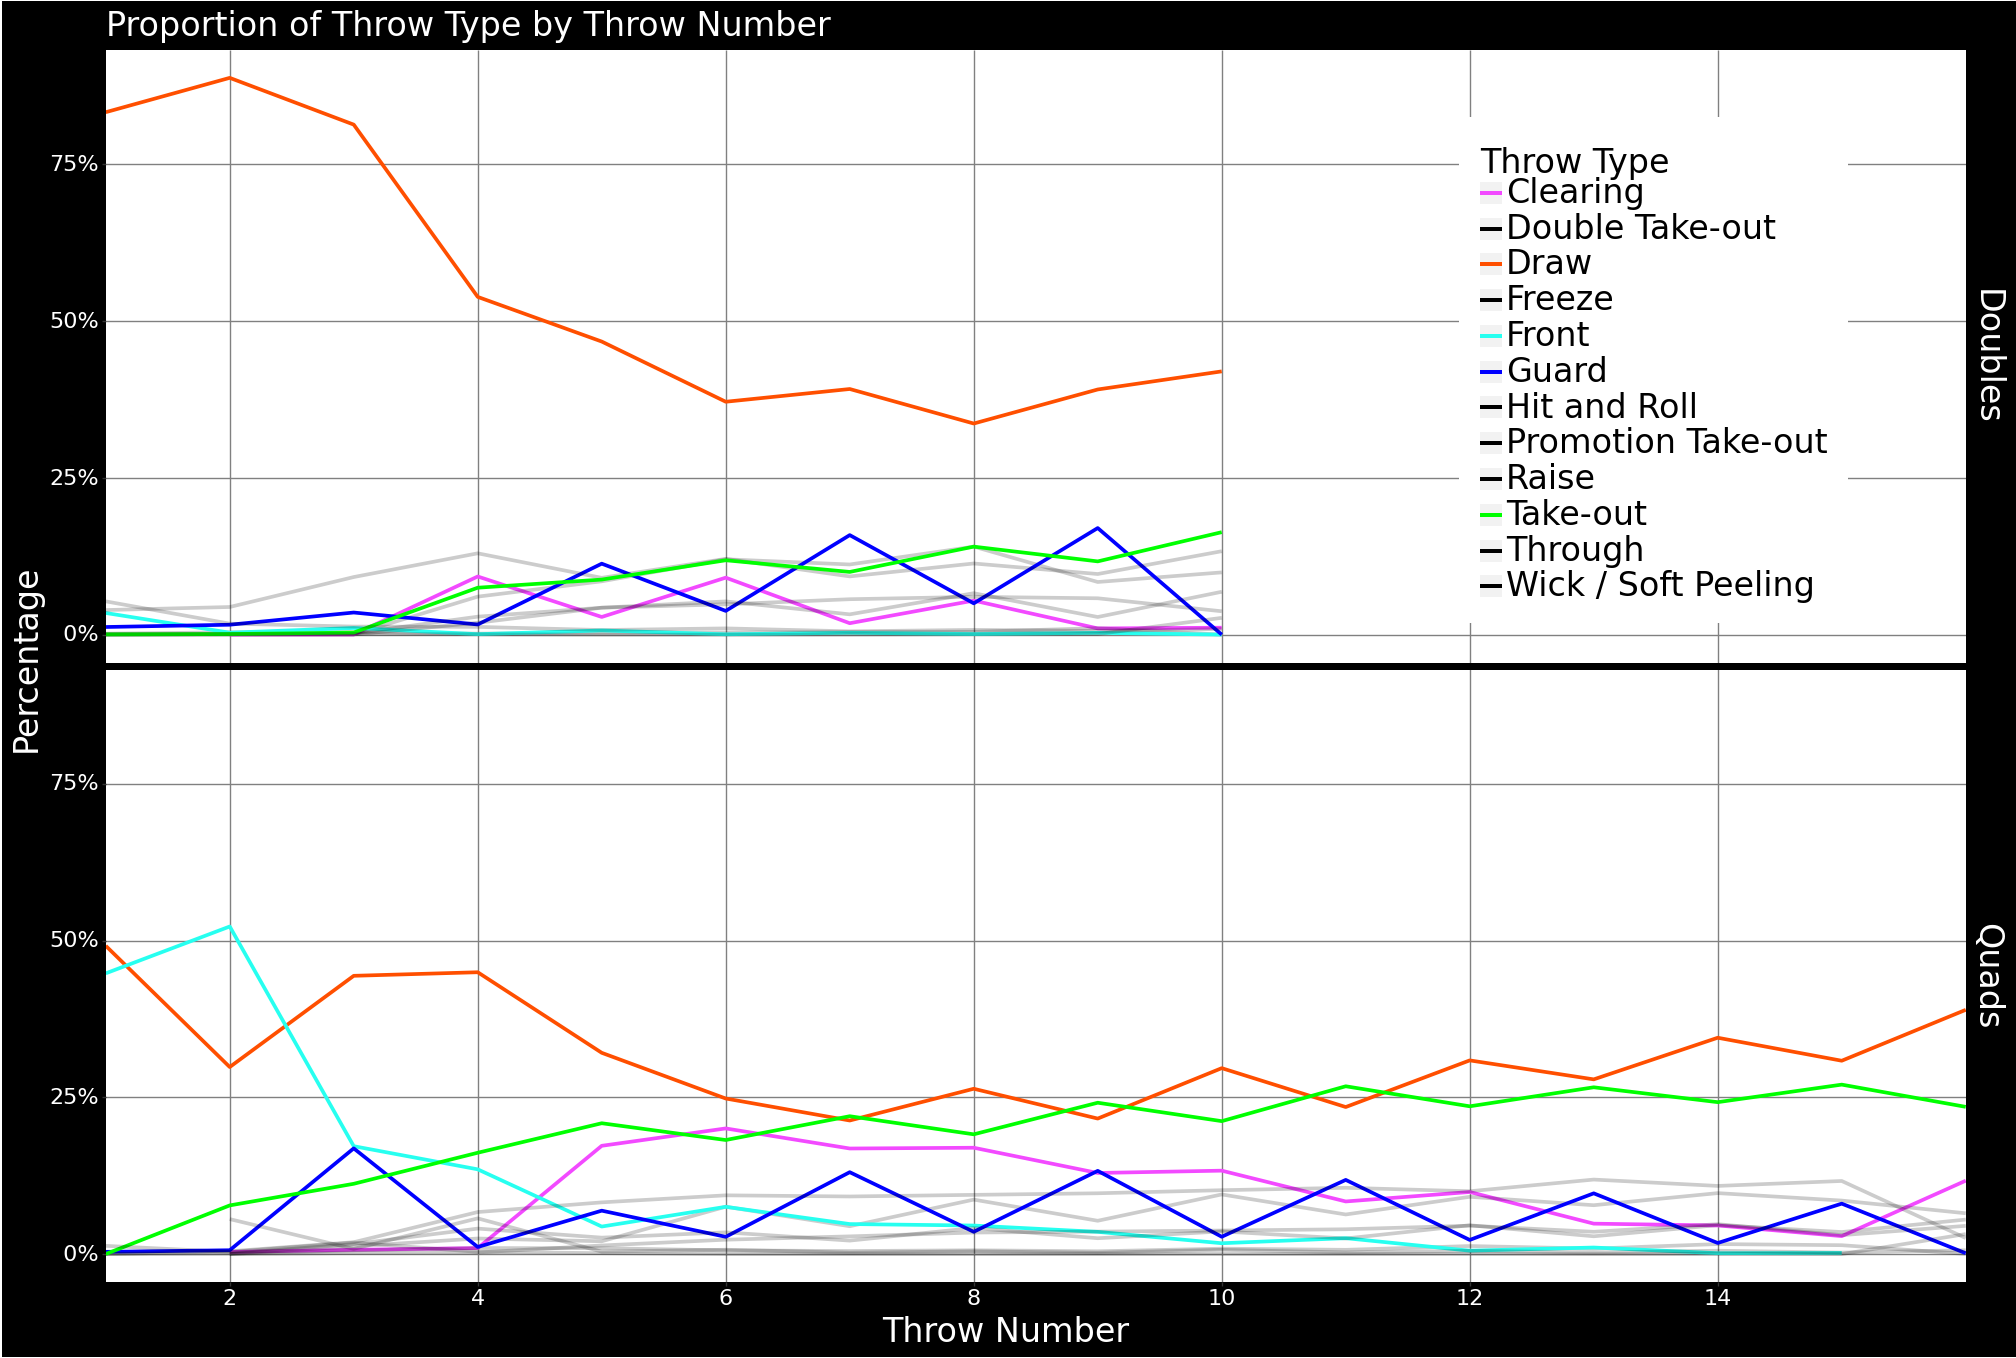

<ggplot: (715079434)>

In [84]:
alphas = defaultdict(lambda: 0.2)
alphas['Draw'] = alphas['Take-out'] = alphas['Front'] = alphas['Guard'] = alphas['Clearing'] = 1.0
colours = defaultdict(lambda: '#000000')
colours['Draw'] = '#ff4f00'
colours['Front'] = '#27FFF0'
colours['Guard'] = '#0000ff'
colours['Take-out'] = '#00ff00'
colours['Clearing'] = '#F24AFF'
g = (gg.ggplot(throw_type_by_end.query('type not in ["through", "not played", "no statistics"]'), gg.aes(x='num', y='perc', colour='factor(type)', alpha='factor(type)')) 
     + gg.geom_line(size=1.5) 

     + gg.facet_grid('team_type ~ .')

     + gg.scale_alpha_manual(values=alphas, guide=False)
     + gg.scale_colour_manual(values=colours)
     + gg.scale_x_continuous(breaks=lambda x: range(int(x[0] + 1), int(x[1]), 2), expand=(0, 0), limits=[1, 16])
     + gg.scale_y_continuous(labels=lambda x: [f"{y:2.0f}%" for y in x])

     + gg.theme(figure_size=(24, 16))
     + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=16))
     + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=24, colour='#000000'), legend_title=gg.element_text(size=24, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.77, 0.68), legend_direction='vertical')
     + gg.theme(panel_grid=gg.element_line(colour='gray'), strip_background=gg.element_rect(fill='#000000'))

     + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
     + pe.remove_grid(minor=True)
     + pe.labels(title='Proportion of Throw Type by Throw Number')
     + gg.labs(colour='Throw Type', x='Throw Number', y='Percentage')
     )
g.save(join(img_dest, 'Throw_Proportion.png'), width=(24), height=(16), limitsize=False, dpi=300)
g

#### Player Rating

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 24 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Player_Rating_Count.png


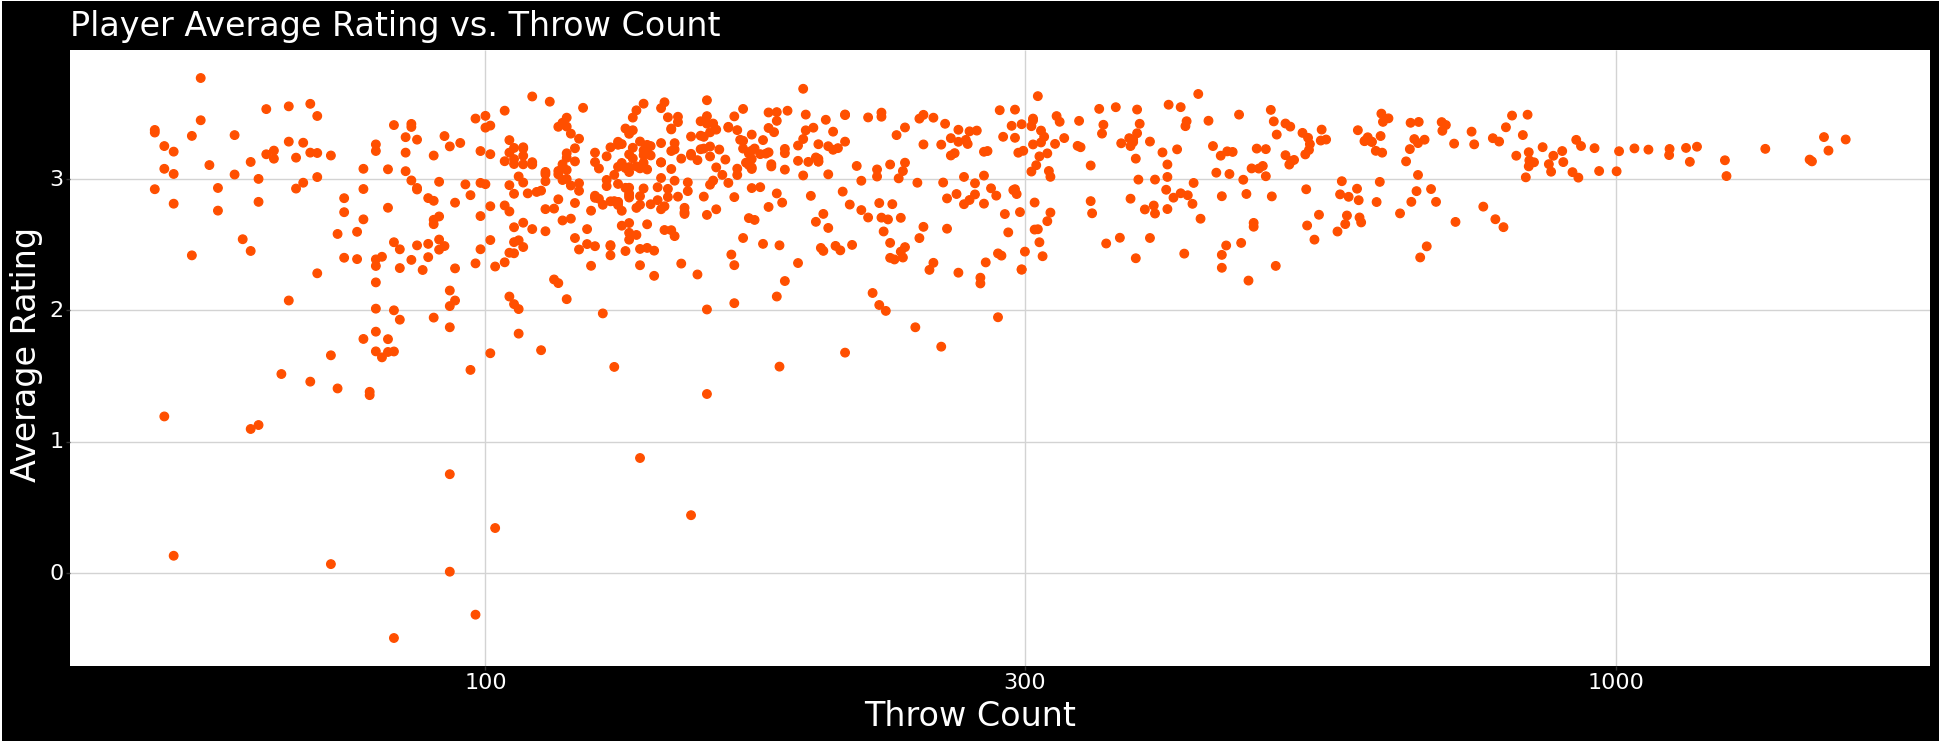

<ggplot: (687787632)>

In [85]:
player_accuracy = throws.groupby(['player', 'nationality', 'sex']).agg({'rating': [('mean', 'mean'), ('count', 'count')]}).reset_index().dropna()
player_accuracy.columns = ['_'.join(col).strip('_') for col in player_accuracy.columns]
player_accuracy = player_accuracy.query('rating_count > 50').reset_index(drop=True)
g = (gg.ggplot(player_accuracy, gg.aes(x='rating_count', y='rating_mean')) 
    + gg.geom_point(size=3, colour='#ff4f00')

    + gg.scale_x_log10()

    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=16))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.83, 0.3))
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.labels(title='Player Average Rating vs. Throw Count')
    + pe.remove_grid(minor=True)
    + gg.theme(figure_size=(24, 8))
    + gg.labs(colour='Team', x='Throw Count', y='Average Rating')
    )
g.save(join(img_dest, 'Player_Rating_Count.png'), width=(24), height=(8), limitsize=False, dpi=300)
g

#### Team Focus Player Rating

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 24 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Player_Rating_Count_Country.png


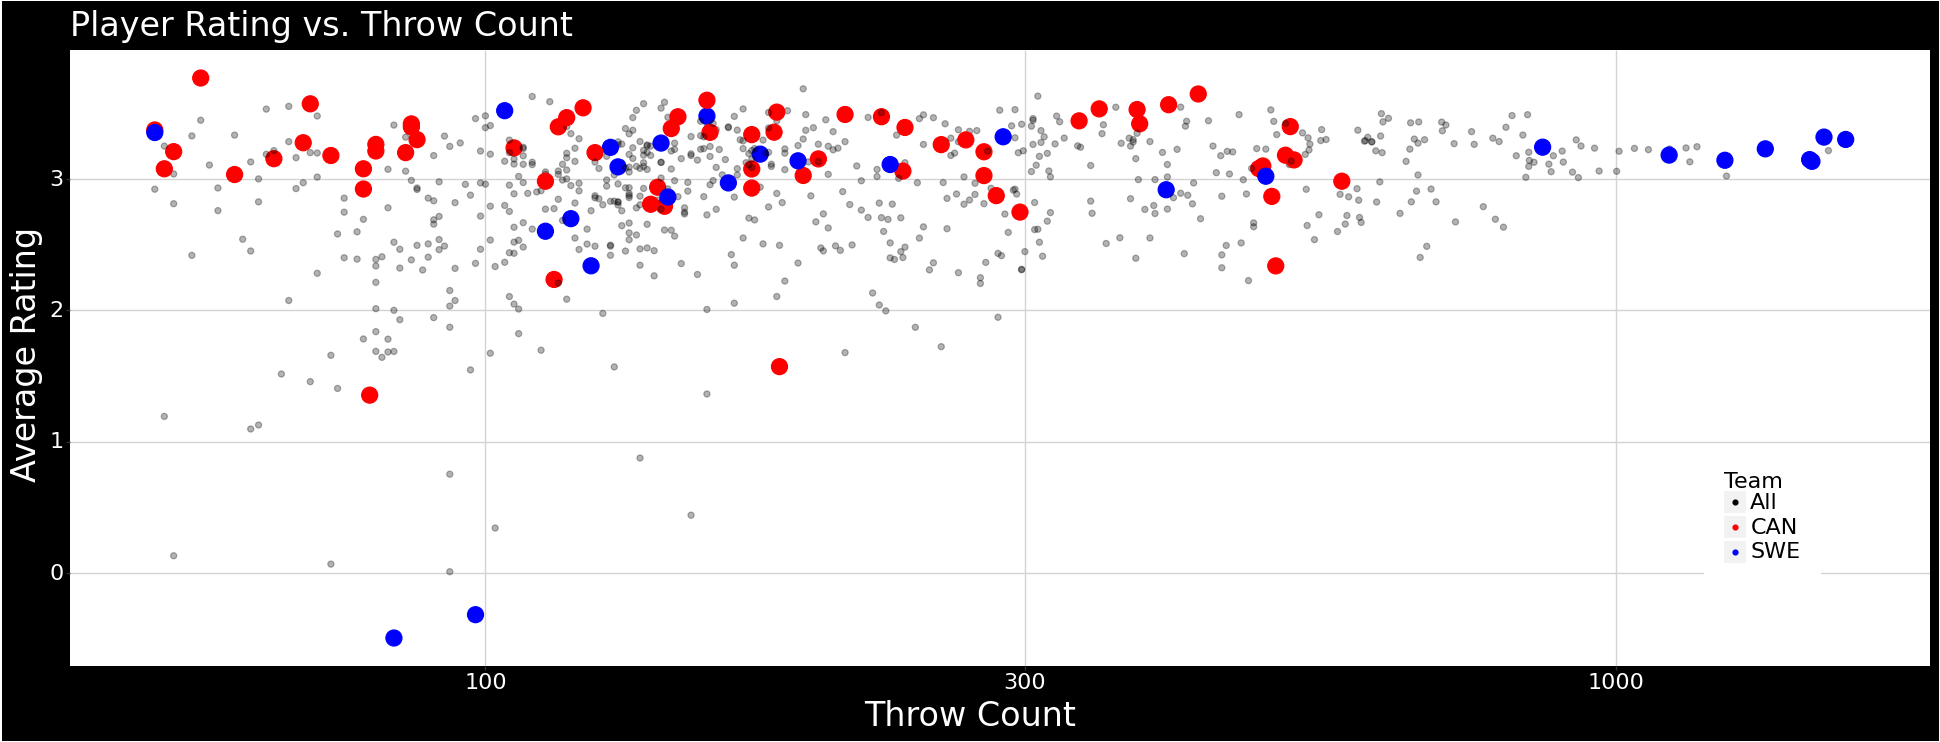

<ggplot: (789513921)>

In [86]:
team_a = 'CAN'
team_a_colour = '#ff0000'
team_b = 'SWE'
team_b_colour = '#0000ff'
player_accuracy['colour_lab'] = player_accuracy.nationality.apply(lambda x: '1' if x.startswith(team_a) else ('2' if x.startswith(team_b) else '0'))
g = (gg.ggplot(player_accuracy, gg.aes(x='rating_count', y='rating_mean', fill='colour_lab', colour='colour_lab', size='colour_lab', alpha='colour_lab')) 
    + gg.geom_point()

    + gg.scale_x_log10()
    + gg.scale_colour_manual(values=['#000000', team_a_colour, team_b_colour], labels=['All', team_a, team_b])
    + gg.scale_fill_manual(values=['#000000', team_a_colour, team_b_colour], guide=False)
    + gg.scale_size_manual(values={'0': 2, '1': 6, '2': 6}, guide=False)
    + gg.scale_alpha_manual(values=[0.3, 1, 1], guide=False)

    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=16))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.83, 0.3), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.labels(title='Player Rating vs. Throw Count')
    + pe.remove_grid(minor=True)
    + gg.theme(figure_size=(24, 8))
    + gg.labs(colour='Team', x='Throw Count', y='Average Rating')
    )
g.save(join(img_dest, 'Player_Rating_Count_Country.png'), width=(24), height=(8), limitsize=False, dpi=300)
g

#### Player Focus Player Rating

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 24 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Player_Rating_Count_Player.png


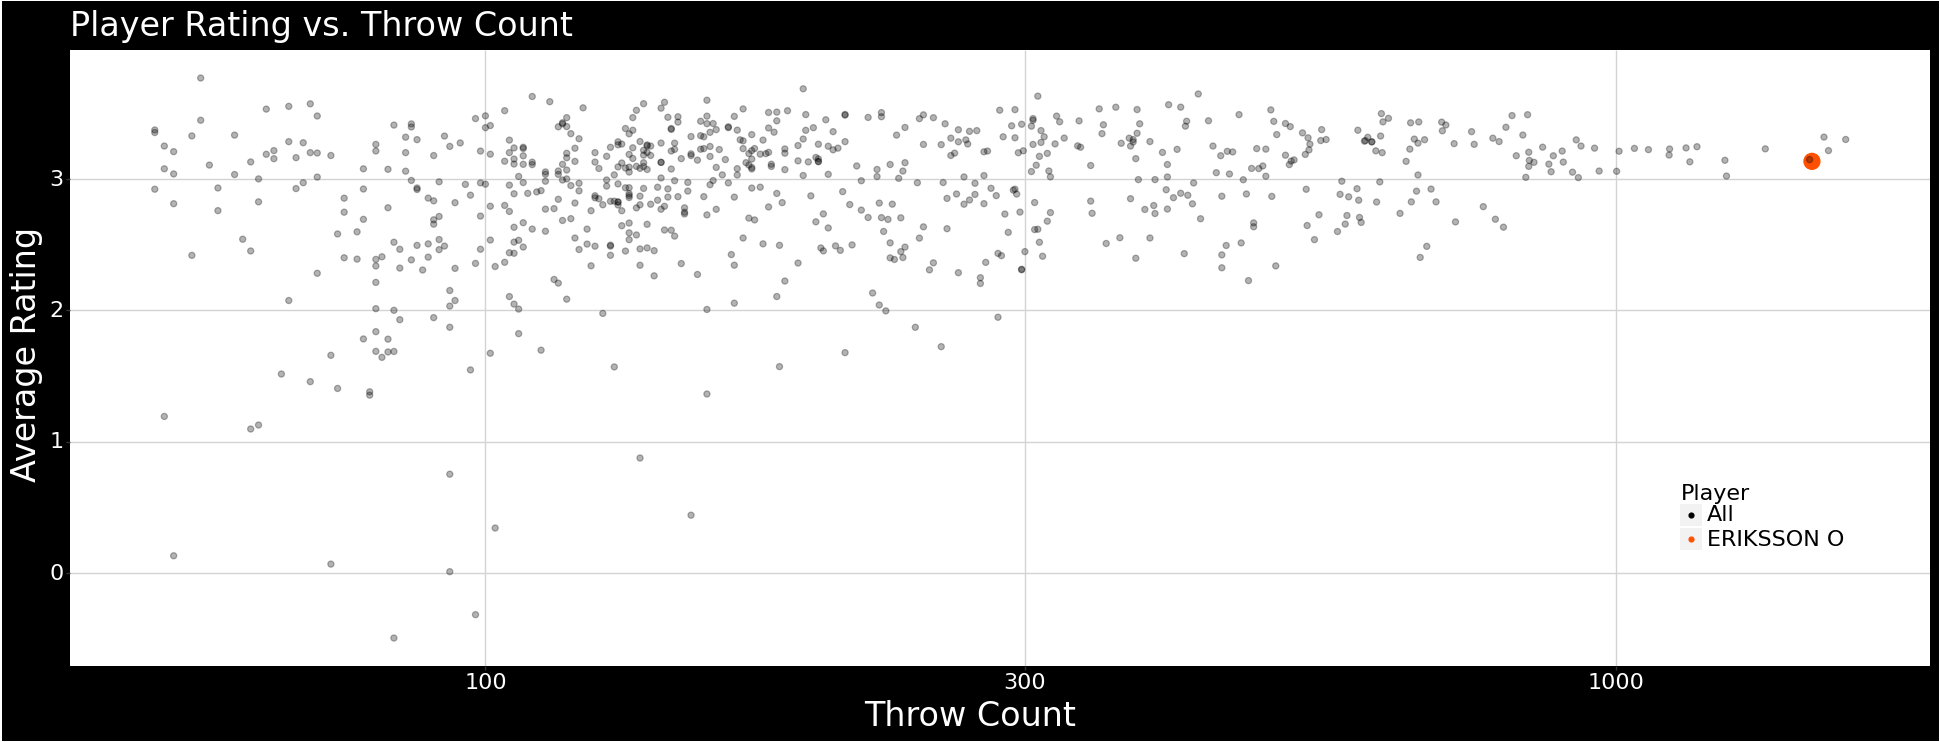

<ggplot: (707980499)>

In [87]:
# player_of_interest_name = 'MARKS A'
player_of_interest_name = 'ERIKSSON O'
# player_of_interest_name = 'STURMAY S'
player_accuracy['player_focus'] = player_accuracy.player.apply(lambda x: '1' if x == player_of_interest_name else '0')
# player_accuracy.player_focus.value_counts()
g = (gg.ggplot(player_accuracy, gg.aes(x='rating_count', y='rating_mean', fill='player_focus', colour='player_focus', size='player_focus', alpha='player_focus')) 
    + gg.geom_point()

    + gg.scale_x_log10()
    + gg.scale_colour_manual(values=['#000000', '#ff4f00'], labels=['All', player_of_interest_name])
    + gg.scale_fill_manual(values=['#000000', '#ff4f00'], guide=False)
    + gg.scale_size_manual(values={'0': 2, '1': 6}, guide=False)
    + gg.scale_alpha_manual(values=[0.3, 1], guide=False)

    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=16))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.83, 0.3), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.labels(title='Player Rating vs. Throw Count')
    + pe.remove_grid(minor=True)
    + gg.theme(figure_size=(24, 8))
    + gg.labs(colour='Player', x='Throw Count', y='Average Rating')
    )
g.save(join(img_dest, 'Player_Rating_Count_Player.png'), width=(24), height=(8), limitsize=False, dpi=300)
g

#### Player List Player Rating

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 24 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Player_Rating_Count_Player_List.png


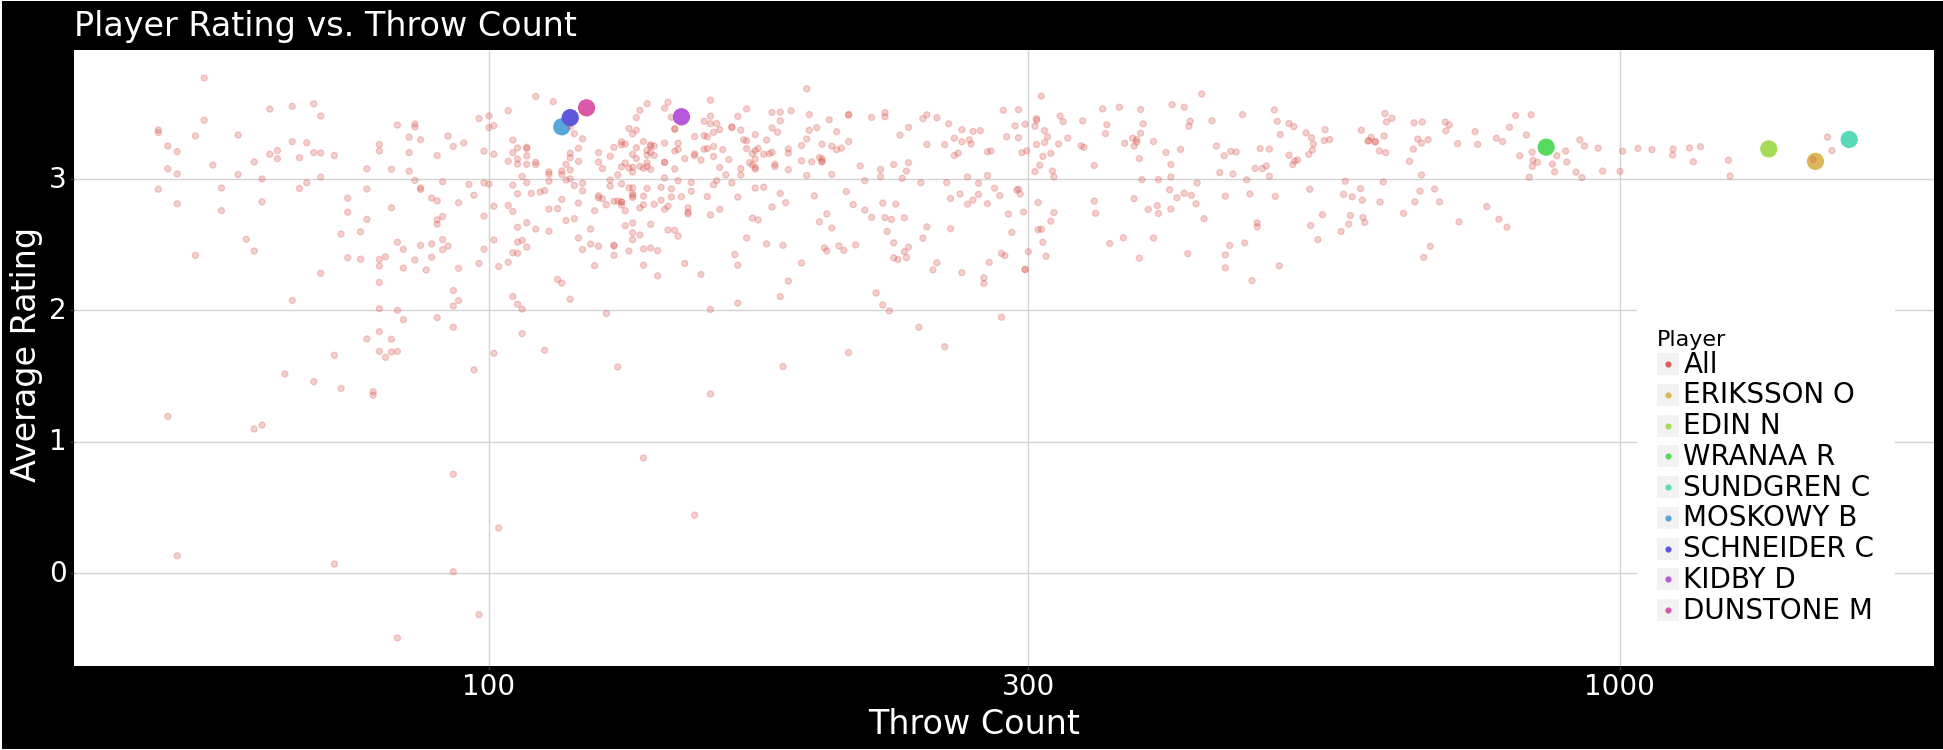

<ggplot: (719295892)>

In [88]:
players_of_interest_name = ['STURMAY S', 'ERIKSSON O', 'MARKS A']
players_of_interest_name = ['KIDBY D', 'SCHNEIDER C', 'MOSKOWY B', 'DUNSTONE M']
players_of_interest_name = ['SUNDGREN C', 'WRANAA R', 'ERIKSSON O', 'EDIN N'] + players_of_interest_name
player_accuracy['player_focus'] = player_accuracy.player.apply(lambda x: x if x in players_of_interest_name else 'All')
player_accuracy['player_focus_mapping'] = player_accuracy.player.apply(lambda x: '1' if x in players_of_interest_name else '0')
# player_accuracy.player_focus.value_counts()
g = (gg.ggplot(player_accuracy, gg.aes(x='rating_count', y='rating_mean', fill='reorder(player_focus, rating_mean)', colour='reorder(player_focus, rating_mean)', size='player_focus_mapping', alpha='player_focus_mapping')) 
    + gg.geom_point()

    + gg.scale_x_log10()
    + gg.scale_colour_discrete()
    + gg.scale_fill_discrete(guide=False)
    + gg.scale_size_manual(values={'0': 2, '1': 6}, guide=False)
    + gg.scale_alpha_manual(values={'0': 0.3, '1': 1}, guide=False)

    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=20))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=20, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.83, 0.35), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'))

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.labels(title='Player Rating vs. Throw Count')
    + pe.remove_grid(minor=True)
    + gg.theme(figure_size=(24, 8))
    + gg.labs(colour='Player', x='Throw Count', y='Average Rating')
    )
g.save(join(img_dest, 'Player_Rating_Count_Player_List.png'), width=(24), height=(8), limitsize=False, dpi=300)
g

# Team Stats

#### Query

In [89]:
end_query = """
SELECT e.num, 
       e.hammer_colour, 
       e.direction, 
       e.team_1_final_score, 
       e.team_2_final_score,
       COALESCE(e.team_1_final_score - LAG(e.team_1_final_score, 1) OVER (PARTITION BY e.match_id ORDER BY e.num), e.team_1_final_score) as points_1,
       COALESCE(e.team_2_final_score - LAG(e.team_2_final_score, 1) OVER (PARTITION BY e.match_id ORDER BY e.num), e.team_2_final_score) as points_2,
       m.start_time,
       m.type,
       m.sheet,
       m.team_1_final_score,
       m.team_2_final_score,
       m.team_1,
       m.team_2,
       m.match_id
FROM End e
JOIN Match m
  ON e.match_id = m.match_id"""
db.execute_query(end_query)
end_df = pd.DataFrame(db.cursor.fetchall(), columns=['end_num', 'hammer_colour', 'direction', 't1e_score', 't2e_score', 't1e_points', 't2e_points', 'start_time', 'game_type', 'sheet', 't1m_score', 't2m_score', 'team_1', 'team_2', 'match_id'])

# Cleaning
end_df = end_df.query('(t1e_score != 99) & (t2e_score != 99) & (t1m_score != 99) & (t2m_score != 99)')
end_df['start_time'] = pd.to_datetime(end_df.start_time)
for col in ['hammer_colour', 'direction', 'game_type', 'sheet', 'team_1', 'team_2']:
    end_df[col] = pd.Categorical(end_df[col])

end_df['score_diff'] = end_df.eval('t1e_points - t2e_points').astype(np.float64)

end_df = end_df.loc[end_df.team_1.str.len() < 5]

end_df['nationality'] = end_df.team_1.apply(lambda x: x[:3])

print(end_df.shape)
end_df.head(10)

(18121, 17)


end_num hammer_colour direction  t1e_score  t2e_score  t1e_points  \
0        1           red      down          0          3           0   
1        2        yellow        up          1          3           1   
2        3           red        up          2          3           1   
3        4        yellow      down          3          3           1   
4        5        yellow        up          3          4           0   
5        6        yellow        up          5          4           2   
6        7           red      down          6          4           1   
7        8        yellow      down          6          5           0   
8        9        yellow      down          7          5           1   
9       10           red        up          7          6           0   

   t2e_points          start_time     game_type sheet  t1m_score  t2m_score  \
0           3 2017-11-04 19:00:00  Womens_Teams     D          7          6   
1           0 2017-11-04 19:00:00  Womens_Teams     D          7          6   
2           0 2017-11-04 19:00:00  Womens_Teams     D          7          6   
3           0 2017-11-04 19:00:00  Womens_Teams     D          7          6   
4           1 2017-11-04 19:00:00  Womens_Teams     D          7          6   
5           0 2017-11-04 19:00:00  Womens_Teams     D          7          6   
6           0 2017-11-04 19:00:00  Womens_Teams     D          7          6   
7           1 2017-11-04 19:00:00  Womens_Teams     D          7          6   
8           0 2017-11-04 19:00:00  Womens_Teams     D          7          6   
9           1 2017-11-04 19:00:00  Womens_Teams     D          7          6   

  team_1 team_2  match_id  score_diff nationality  
0    NZL    AUS         1        -3.0         NZL  
1    NZL    AUS         1         1.0         NZL  
2    NZL    AUS         1         1.0         NZL  
3    NZL    AUS         1         1.0         NZL  
4    NZL    AUS         1        -1.0         NZL  
5    NZL    AUS         1         2.0         NZL  
6    NZL    AUS         1         1.0         NZL  
7    NZL    AUS         1        -1.0         NZL  
8    NZL    AUS         1         1.0         NZL  
9    NZL    AUS         1        -1.0         NZL

#### Team Average and Range - End

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 30 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Team_End_Score.png


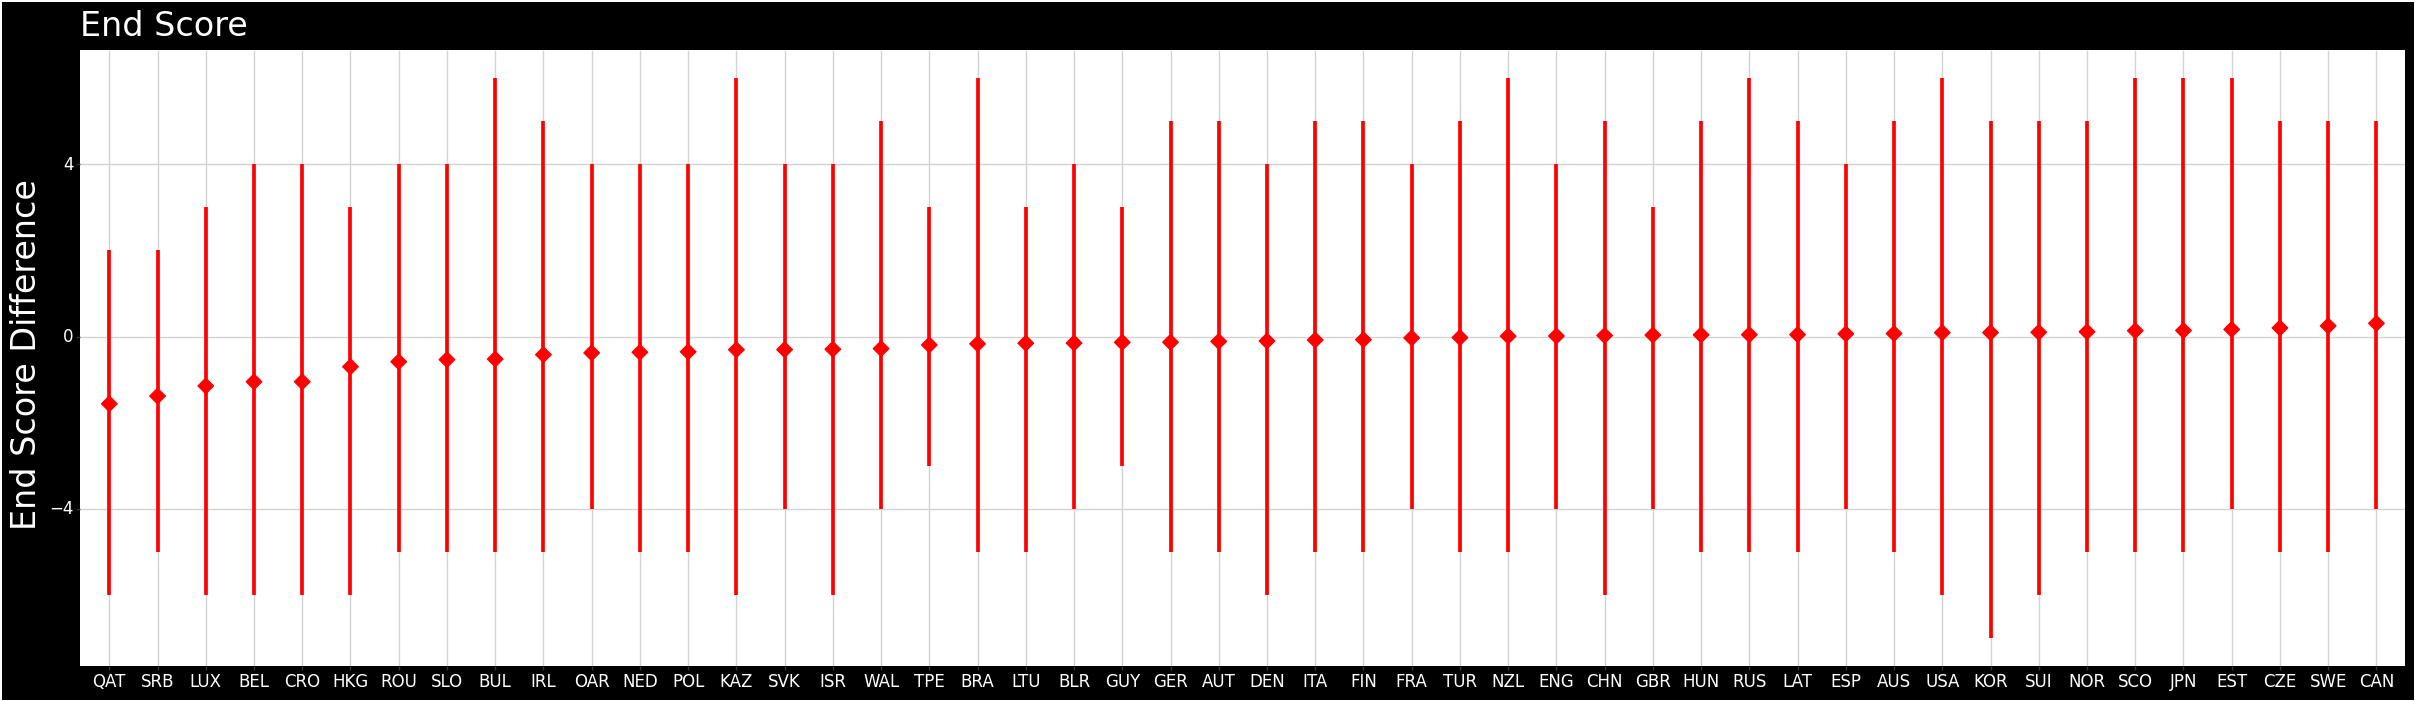

<ggplot: (792482835)>

In [90]:
team_ends = end_df.groupby(['nationality']).agg({'score_diff': ['min', 'max', 'mean', 'count']}).reset_index()
team_ends.columns = ['_'.join(col).strip('_') for col in team_ends.columns]
team_ends
g = (gg.ggplot(team_ends.query('score_diff_count > 40'), gg.aes(x='reorder(nationality, score_diff_mean)', y='score_diff_mean', ymin='score_diff_min', ymax='score_diff_max')) 
    + gg.geom_point(size=4, colour='#ff0000', shape='D')
    + gg.geom_linerange(size=1.5, colour='#ff0000')

    + gg.theme(figure_size=(30, 8))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=12))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.83, 0.3), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'), axis_title_x=blank)

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.labels(title='End Score')
    + pe.remove_grid(minor=True)
    + gg.theme(figure_size=(30, 8))
    + gg.labs(colour='Player', y='End Score Difference')
    )
g.save(join(img_dest, 'Team_End_Score.png'), width=(30), height=(8), limitsize=False, dpi=300)
g

#### Progression of score throughout match

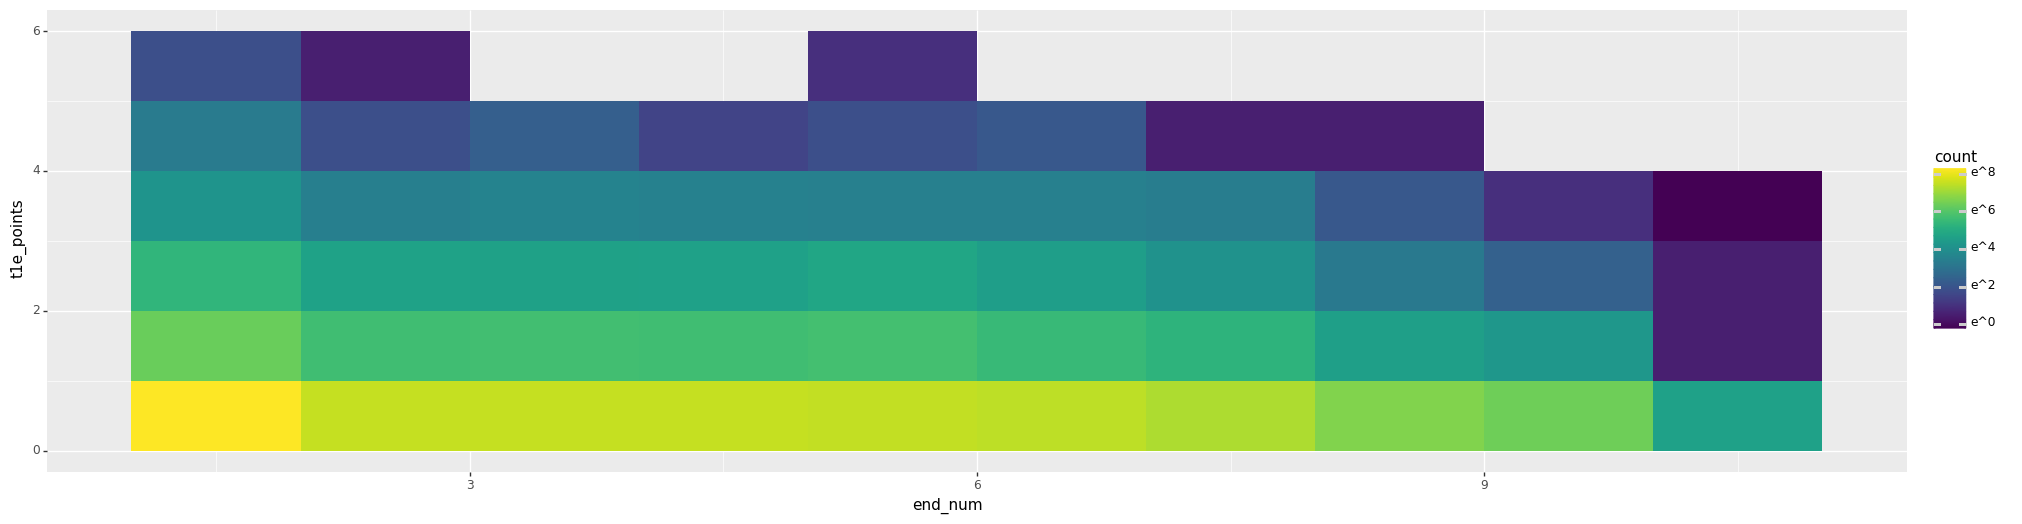

<ggplot: (709708954)>

In [91]:
# TODO:
# Average score for each end, depending on hammer
(gg.ggplot(end_df.query('match_id < 2000'), gg.aes(x='end_num', y='t1e_points')) 
    + gg.geom_bin_2d(binwidth=1)

    + gg.scale_fill_continuous(trans='log')

    + gg.theme(figure_size=(24, 6))
    )

/var/folders/zz/z3rhbf4x4hdb8gwyxnpw92_40000gn/T/ipykernel_63822/496733443.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


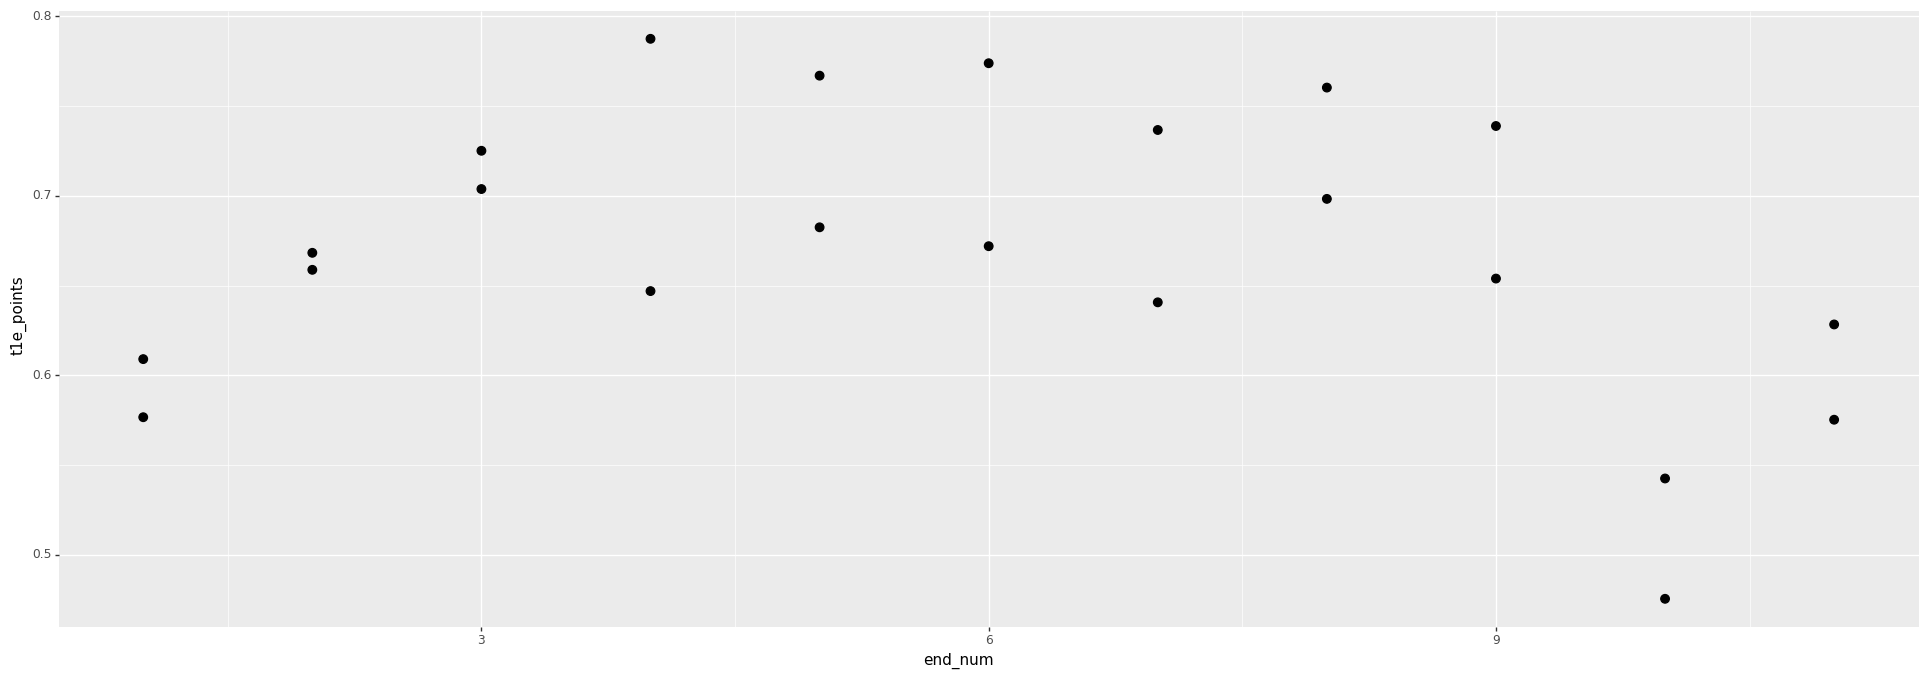

<ggplot: (712080433)>

In [92]:
(gg.ggplot(end_df.query('game_type in ["Mens_Teams", "Womens_Teams"]').groupby(['end_num']).agg('mean').reset_index(), gg.aes(x='end_num'))
    + gg.geom_point(gg.aes(y='t1e_points'), size=3)
    + gg.geom_point(gg.aes(y='t2e_points'), size=3)

    # + gg.geom_point(gg.aes(y='t1e_score'), size=3, colour='blue')
    # + gg.geom_point(gg.aes(y='t2e_score'), size=3, colour='red')

    # + gg.lims(y=(0, 1))

    + gg.theme(figure_size=(24, 8))
    )

#### Query

In [93]:
match_query = """
SELECT match_id,
       start_time,
       type,
       team_1,
       team_2, 
       team_1_final_score,
       team_2_final_score
FROM Match"""
db.execute_query(match_query)
match_df = pd.DataFrame(db.cursor.fetchall(), columns=['match_id', 'start_time', 'type', 'team_1', 'team_2', 'team_1_score', 'team_2_score'])

# Cleaning
match__df = match_df.query('(team_1_score != 99) & (team_2_score != 99)')
match_df['start_time'] = pd.to_datetime(match_df.start_time)
for col in ['type']:
    match_df[col] = pd.Categorical(match_df[col])

match_df = match_df.loc[match_df.team_1.str.len() < 5]

match_df['nationality'] = match_df.team_1.apply(lambda x: x[:3])

match_df['score_diff'] = match_df.apply(lambda x: x['team_1_score'] - x['team_2_score'], axis=1)

print(match_df.shape)
match_df.head()

(2162, 9)


match_id          start_time          type team_1 team_2  team_1_score  \
0         1 2017-11-04 19:00:00  Womens_Teams    NZL    AUS             7   
1         2 2017-11-03 14:00:00  Womens_Teams    JPN    CHN             3   
2         3 2017-11-03 19:00:00    Mens_Teams    AUS    NZL             9   
3         4 2017-03-22 09:00:00  Womens_Teams    ITA    SUI             2   
4         5 2017-03-21 19:00:00  Womens_Teams    CAN    SCO             8   

   team_2_score nationality  score_diff  
0             6         NZL           1  
1             5         JPN          -2  
2             3         AUS           6  
3            10         ITA          -8  
4             2         CAN           6

#### Team Average and Range - Match

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 30 x 8 in image.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/lucasnieuwenhout/Documents/Programming/Websites/nwnht.github.io/projects/curling/assets/Team_Match_Score.png


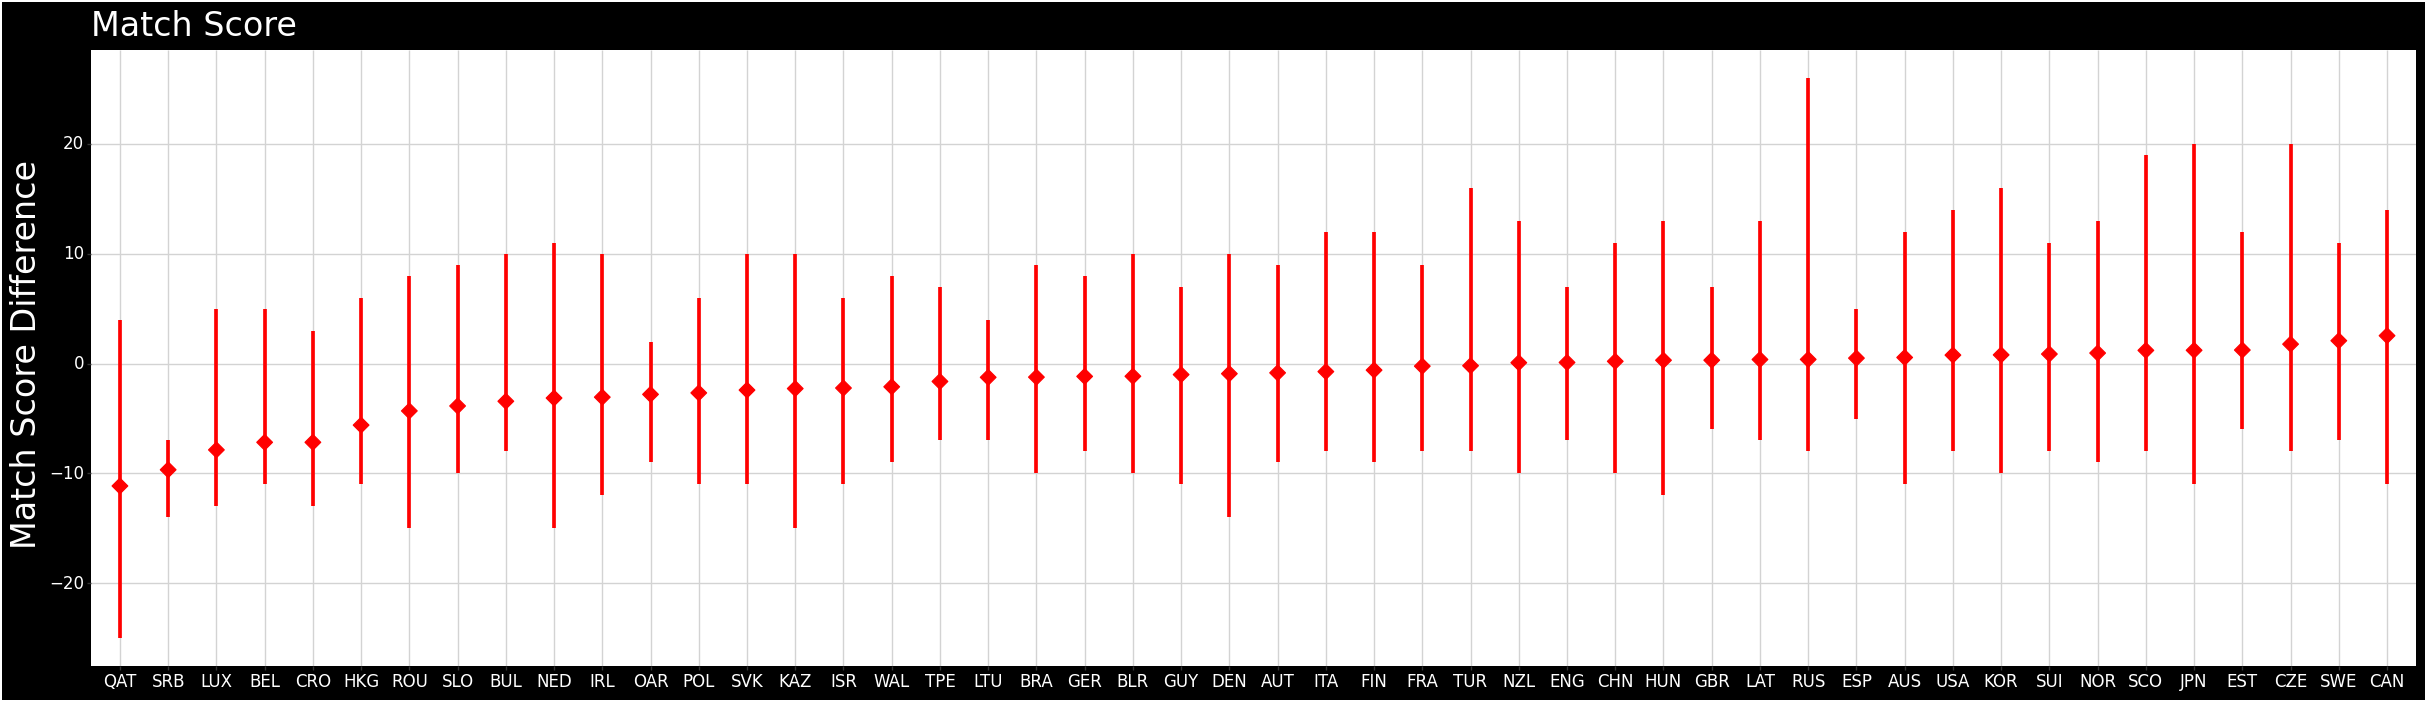

<ggplot: (714434151)>

In [94]:
team_matches = match_df.groupby(['nationality']).agg({'score_diff': ['min', 'max', 'mean', 'count']}).reset_index()
team_matches.columns = ['_'.join(col).strip('_') for col in team_matches.columns]
g = (gg.ggplot(team_matches.query('score_diff_count > 5'), gg.aes(x='reorder(nationality, score_diff_mean)', y='score_diff_mean', ymin='score_diff_min', ymax='score_diff_max')) 
    + gg.geom_point(size=4, colour='#ff0000', shape='D')
    + gg.geom_linerange(size=1.5, colour='#ff0000')

    + gg.theme(figure_size=(30, 8))
    + gg.theme(text=gg.element_text(colour='#ffffff', size=24), title=gg.element_text(size=24, ha='left'), axis_text=gg.element_text(size=12))
    + gg.theme(axis_title=gg.element_text(ha='center'), legend_text=gg.element_text(size=16, colour='#000000'), legend_title=gg.element_text(size=16, colour='#000000'), legend_background=gg.element_rect(fill='#ffffff'), legend_position=(0.83, 0.3), legend_direction='vertical')
    + gg.theme(panel_grid=gg.element_line(colour='lightgray'), axis_title_x=blank)

    + pe.background_colour(panel_colour='#ffffff', plot_colour='#000000')
    + pe.labels(title='Match Score')
    + pe.remove_grid(minor=True)
    + gg.theme(figure_size=(30, 8))
    + gg.labs(colour='Player', y='Match Score Difference')
    )
g.save(join(img_dest, 'Team_Match_Score.png'), width=(30), height=(8), limitsize=False, dpi=300)
g

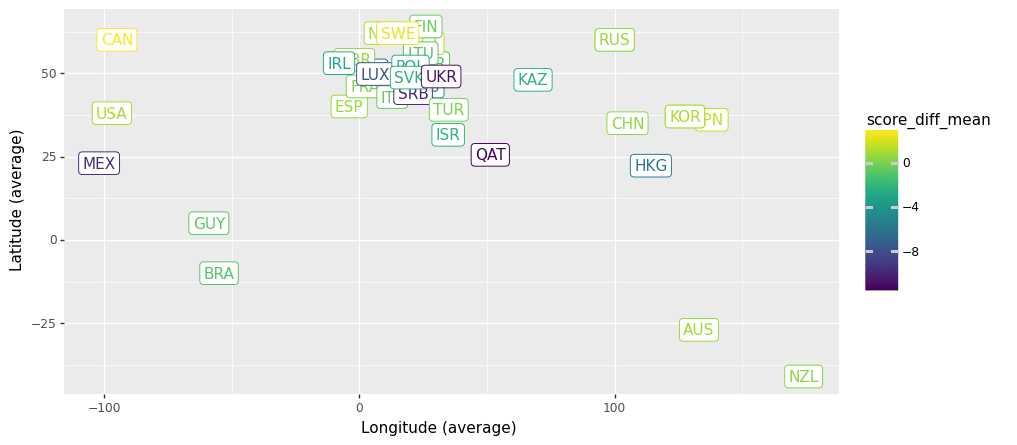

<ggplot: (789454159)>

In [95]:
country_conv = pd.read_csv('./utils/countries_codes_and_coordinates.csv')
country_conv['Alpha-3 code'] = country_conv['Alpha-3 code'].str.strip('" ')
country_conv['Latitude (average)'] = country_conv['Latitude (average)'].str.strip('" ').astype('float')
country_conv['Longitude (average)'] = country_conv['Longitude (average)'].str.strip('" ').astype('float')
team_location = team_matches.merge(country_conv, how='inner', left_on='nationality', right_on='Alpha-3 code')
(gg.ggplot(team_location, gg.aes(x='Longitude (average)', y='Latitude (average)', colour='score_diff_mean'))
    + gg.geom_point()
    + gg.geom_label(gg.aes(label='Alpha-3 code'))
    + gg.theme(figure_size=(10, 5))
    )

In [96]:
print(pearsonr(team_location['score_diff_mean'], team_location['Latitude (average)']))
print(pearsonr(team_location['score_diff_mean'], team_location['Longitude (average)']))

PearsonRResult(statistic=0.05274407393265428, pvalue=0.7498084499429336)
PearsonRResult(statistic=0.14190484137909826, pvalue=0.38883310800283866)


In [ ]:
"""
SELECT customer_id,
       customer_name,
       DATE_EXTRACT(‘year’, billing_creation_date),
       SUM(billing) / COUNT(*) OVER (PARTITION BY DATE_EXTRACT(‘year’, billing_date))
FROM billing
WHERE billing_creation_date BETWEEN 2019-01-01 AND 2022-12-31
GROUP BY 1, 3
"""

"""
SELECT sub.customer_id,
       sub.customer_name,
       SUM(sub.year_sum) / 3
FROM 
    (
    SELECT customer_id,
           customer_name,
           STRFTIME('%Y', billing_creation_date) AS year,
           COALESCE(SUM(billed_amount), 0) AS year_sum
    FROM
        billing
    WHERE billing_creation_date BETWEEN 2019-01-01 AND 2021-12-31
    GROUP BY 1, 2
    ) sub
GROUP BY 1

"""

"""
SELECT customer_id,
       customer_name,
       SUM(billing) / COUNT(*)
FROM billing
WHERE date
GROUP BY 1
"""

# Rest

In [334]:
print(chisquare([0.45, 0.55]))
((0.45 - 0.5)**2)/0.5 + ((0.55 - 0.5)**2)/0.5

Power_divergenceResult(statistic=0.010000000000000005, pvalue=0.920344325445942)


0.010000000000000005

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 149'. Pick better value with 'binwidth'.


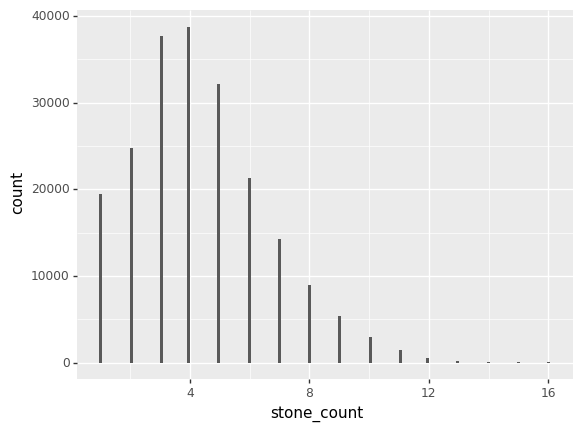

<ggplot: (704770256)>

In [335]:
gg.ggplot(throws, gg.aes(x='stone_count')) + gg.geom_histogram()

In [336]:
men_mean = throws.query('sex != "u"').groupby(['sex']).agg({'stone_count': ['mean', 'count']})[('stone_count', 'mean')]['f']
population_mean = throws.query('sex != "u"').agg({'stone_count': ['mean', 'count']}).loc['mean'].values[0]
men_std = tstd(throws.query('sex == "f"')['stone_count'])
len_men = len(throws.query('sex == "f"'))

In [337]:
(men_mean - population_mean) / (men_std / np.sqrt(len_men))
# This is less than the two tailed 0.05 of 1.96, This means that it is not significant

-1.8865207183345216

In [338]:
ttest_1samp(throws.query('sex == "f"')['stone_count'], popmean=population_mean)

Ttest_1sampResult(statistic=-1.8865207183345216, pvalue=0.05922858726716065)

In [339]:
ttest_ind(throws.query('sex == "m"')['stone_count'], throws.query('sex == "f"')['stone_count'])

Ttest_indResult(statistic=2.683267439176385, pvalue=0.00729139556829869)

In [340]:
def stat(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
i = permutation_test((throws.query('sex == "m"')['stone_count'],throws.query('sex == "f"')['stone_count']), statistic=stat, vectorized=True)

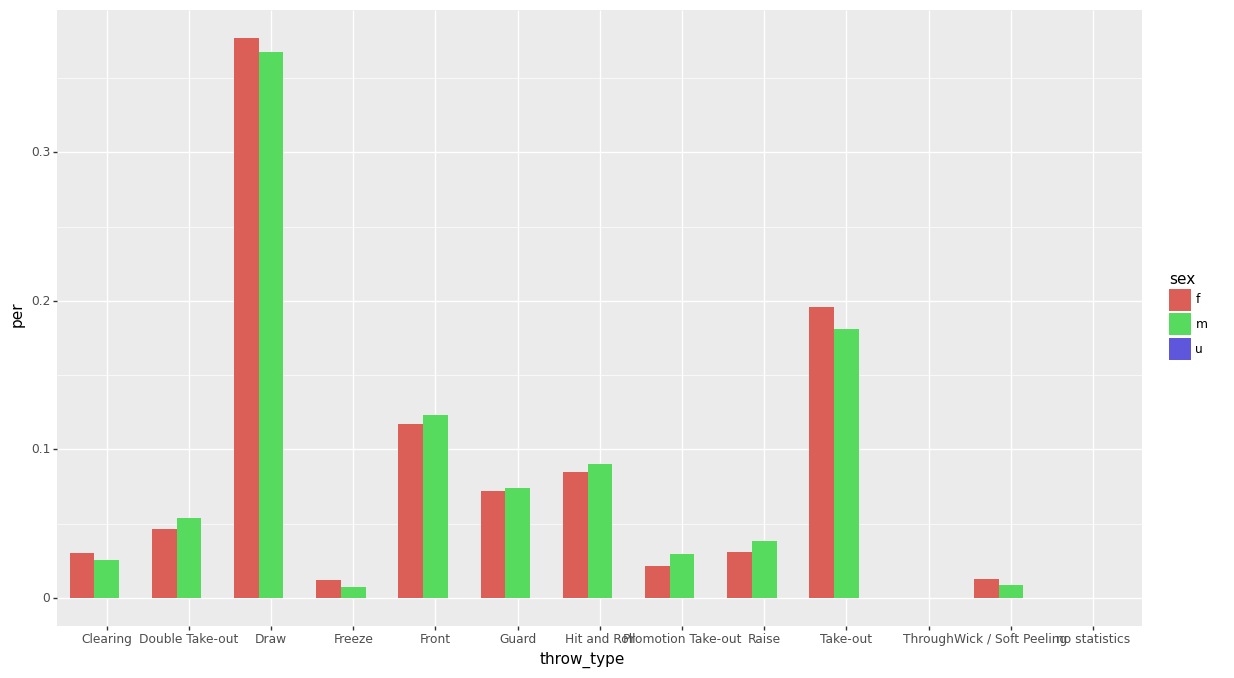

<ggplot: (718911883)>

In [ ]:
female_count = throws.query('(match_type in ["Womens_Teams", "Mens_Teams"]) & (throw_type != "no statistics")').groupby('sex').agg({'player':'count'}).loc['f'].values[0]
male_count = throws.query('(match_type in ["Womens_Teams", "Mens_Teams"]) & (throw_type != "no statistics")').groupby('sex').agg({'player':'count'}).loc['m'].values[0]
throw_type = throws.query('sex != "u"').query('(match_type in ["Womens_Teams", "Mens_Teams"]) & (throw_type != "no statistics")').groupby(['sex', 'throw_type']).agg({'player': 'count'}).reset_index()
throw_type['per'] = throw_type.apply(lambda x: x['player']/male_count if x['sex'] == 'm' else x['player']/female_count, axis=1)
throw_type
(gg.ggplot(throw_type, gg.aes(x='throw_type', y='per', fill='sex')) 
    + gg.geom_col(position='dodge')
    + gg.theme(figure_size=(14, 8))
    )

In [ ]:
throw_type = throw_type.query('(sex != "u") & (throw_type != "no statistics")')
throw_type
chi2_contingency((throw_type.query('(sex == "f") & (throw_type != "no statistics")')['player'], throw_type.query('(sex == "m") & (throw_type != "no statistics")')['player']))

(452.5127419102612,
 4.203768975408202e-90,
 11,
 array([[1.87381328e+03, 3.42186916e+03, 2.52924664e+04, 6.43488916e+02,
         8.16895723e+03, 4.95387322e+03, 5.96466542e+03, 1.74351032e+03,
         2.36811475e+03, 1.27772443e+04, 6.60957067e+00, 7.21387427e+02],
        [2.09518672e+03, 3.82613084e+03, 2.82805336e+04, 7.19511084e+02,
         9.13404277e+03, 5.53912678e+03, 6.66933458e+03, 1.94948968e+03,
         2.64788525e+03, 1.42867557e+04, 7.39042933e+00, 8.06612573e+02]]))

/var/folders/zz/z3rhbf4x4hdb8gwyxnpw92_40000gn/T/ipykernel_92479/2647355295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


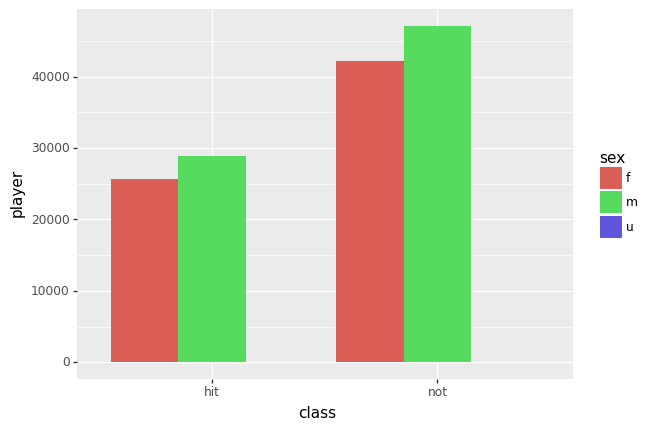

<ggplot: (691609287)>

In [ ]:
hit_types = ['Clearing', 'Double Take-out', 'Hit and Roll', 'Promotion Take-out', 'Take-out']
throw_type['class'] = throw_type.apply(lambda x: 'hit' if x['throw_type'] in hit_types else 'not', axis=1)
throw_hit_not = throw_type.groupby(['sex', 'class']).agg({'player':'sum'})
gg.ggplot(throw_hit_not.reset_index(), gg.aes(x='class', y='player', fill='sex')) + gg.geom_col(position='dodge')

In [ ]:
throw_hit_not
chi2_contingency((throw_hit_not.reset_index().query('sex == "f"')['player'], throw_hit_not.reset_index().query('sex == "m"')['player']))

(0.573665237719048,
 0.4488061134555671,
 1,
 array([[25781.10250316, 42154.89749684],
        [28826.89749684, 47135.10250316]]))